In [2]:
# Основные библиотеки для анализа данных
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

from scipy.stats import pearsonr # для расчета корреляции Пирсона

In [3]:
# Загрузка файлов
indices_df = pd.read_csv('combined_indices.csv')
companies_df = pd.read_csv('combined_companies.csv')
news_df = pd.read_csv('news_summary_dayly.csv')

In [4]:
# Преобразование дат
indices_df['date'] = pd.to_datetime(indices_df['date'])
companies_df['date'] = pd.to_datetime(companies_df['date'])
news_df['published_date'] = pd.to_datetime(news_df['published_date'])

In [5]:
# Индексы
print("Датасет индексов:", indices_df.shape)
print(f"Период: {indices_df['date'].min().date()} - {indices_df['date'].max().date()}")
print(f"Индексы: {indices_df['label'].unique()}")

# Компании
print("\nДатасет компаний:", companies_df.shape)
print(f"Период: {companies_df['date'].min().date()} - {companies_df['date'].max().date()}")
print(f"Компании: {companies_df['label'].unique()}")

# Новости
print("\nДатасет новостей:", news_df.shape)
print(f"Период: {news_df['published_date'].min().date()} - {news_df['published_date'].max().date()}")

Датасет индексов: (8295, 5)
Период: 2017-01-05 - 2025-04-11
Индексы: ['IMOEX' 'MOEXFN' 'OilGas' 'RTSI']

Датасет компаний: (10177, 5)
Период: 2017-01-10 - 2025-04-11
Компании: ['Gazprom' 'Lukoil' 'Magnit' 'Sberbank' 'Yandex']

Датасет новостей: (2609, 19)
Период: 2017-01-01 - 2025-02-27


In [6]:
# Так как все датасеты имеют разные размеры, то ищем пересечение дат между датасетами
# Получаем множества дат
indices_dates = set(indices_df['date'].dt.date)
companies_dates = set(companies_df['date'].dt.date)
news_dates = set(news_df['published_date'].dt.date)

# Вычисляем пересечения
all_intersection = indices_dates.intersection(companies_dates).intersection(news_dates)

print(f"Пересечение дат всех трех датасетов: {len(all_intersection)} дней")

Пересечение дат всех трех датасетов: 1776 дней


In [7]:
# Описательная статистика финансовых данных
# Статистика для индексов
indices_stats = indices_df[['return', 'volatility_5d', 'value']].describe()#.round(2)
#indices_stats['value'] = indices_stats['value'].apply(lambda x: f"{x:,.2f}")
indices_stats

,return,volatility_5d,value
count,8295.000000,8295.000000,8.295000e+03
mean,0.000078,0.012468,2.535115e+10
std,0.018507,0.013530,3.059495e+10
min,-0.501500,0.000746,0.000000e+00
25%,-0.006313,0.006702,2.608059e+09
50%,0.000682,0.009842,1.579622e+10
75%,0.007675,0.014332,3.366670e+10
max,0.232044,0.268904,4.694049e+11


In [8]:
# Статистика для компаний
companies_stats = companies_df[['return', 'volatility_5d', 'value']].describe()
companies_stats


,return,volatility_5d,value
count,10177.000000,10177.000000,1.017700e+04
mean,0.000131,0.017016,6.319269e+09
std,0.022570,0.014563,8.470857e+09
min,-0.460790,0.000347,5.945872e+06
25%,-0.008967,0.009412,1.577417e+09
50%,0.000000,0.013761,3.747245e+09
75%,0.010061,0.020223,8.389470e+09
max,0.222751,0.223231,2.385837e+11


In [9]:
#Статистика по отдельным компаниям
# Группировка по компаниям
company_stats = companies_df.groupby('label')[['return', 'volatility_5d', 'value']].agg(['mean', 'median', 'std', 'min', 'max'])
company_stats

return                                         volatility_5d  \
              mean    median       std       min       max          mean   
label                                                                      
Gazprom  -0.000077 -0.000470  0.022972 -0.363200  0.222751      0.016328   
Lukoil    0.000314  0.000163  0.019734 -0.258220  0.143438      0.015326   
Magnit   -0.000413 -0.000607  0.021488 -0.328504  0.123979      0.016895   
Sberbank  0.000276  0.000519  0.022586 -0.455918  0.121320      0.016715   
Yandex    0.000608  0.000778  0.026006 -0.460790  0.151258      0.020151   

                                                         value                \
            median       std       min       max          mean        median   
label                                                                          
Gazprom   0.012738  0.015836  0.000960  0.193422  8.590634e+09  5.535697e+09   
Lukoil    0.012235  0.012561  0.000347  0.150809  5.163931e+09  4.102772e+09   
Magnit    0.014022  0.012800  0.001280  0.175441  1.819085e+09  1.412960e+09   
Sberbank  0.013396  0.014731  0.000990  0.214974  1.323959e+10  1.059306e+10   
Yandex    0.016708  0.016275  0.000944  0.223231  2.358459e+09  1.117758e+09   

                                                   
                   std          min           max  
label                                              
Gazprom   9.369232e+09   94080186.2  1.170773e+11  
Lukoil    4.044275e+09   73772538.5  3.601860e+10  
Magnit    1.637950e+09   58706389.5  1.876096e+10  
Sberbank  1.171157e+10  352894151.0  2.385837e+11  
Yandex    4.558489e+09    5945872.0  1.163912e+11

In [10]:
#Добавление столбца года и анализ по годам
#Добавление столбца года
indices_df['year'] = indices_df['date'].dt.year
companies_df['year'] = companies_df['date'].dt.year
news_df['year'] = news_df['published_date'].dt.year

# Статистика по годам для индексов
indices_by_year = indices_df.groupby('year')[['return', 'volatility_5d', 'value']].agg(['mean', 'median', 'std'])
indices_by_year


return                     volatility_5d                      \
          mean    median       std          mean    median       std   
year                                                                   
2017 -0.000326 -0.000297  0.009775      0.008768  0.007996  0.004309   
2018  0.000123  0.000362  0.012352      0.010535  0.009451  0.006598   
2019  0.001072  0.000818  0.008068      0.007337  0.006874  0.003091   
2020 -0.000014  0.001564  0.020384      0.015831  0.012425  0.011706   
2021  0.000822  0.001498  0.012755      0.011562  0.010418  0.005497   
2022 -0.002356  0.000523  0.040308      0.024878  0.016701  0.032252   
2023  0.001361  0.001342  0.010240      0.009223  0.008355  0.004217   
2024 -0.000336  0.000195  0.014412      0.011585  0.010137  0.007529   
2025  0.000348 -0.001993  0.019127      0.016080  0.015240  0.007987   

             value                              
              mean        median           std  
year                                            
2017  1.305451e+10  9.566661e+09  1.270434e+10  
2018  1.746721e+10  1.311943e+10  1.696877e+10  
2019  1.948868e+10  1.362802e+10  1.848581e+10  
2020  3.430310e+10  2.273392e+10  3.567656e+10  
2021  3.792638e+10  2.516448e+10  3.839181e+10  
2022  2.427351e+10  1.061514e+10  4.118638e+10  
2023  2.169284e+10  1.536016e+10  2.235386e+10  
2024  2.986488e+10  1.982525e+10  3.121962e+10  
2025  4.146926e+10  2.887426e+10  4.271999e+10

In [11]:
#Статистика по годам для компаний
companies_by_year = companies_df.groupby('year')[['return', 'volatility_5d', 'value']].agg(['mean', 'median', 'std'])
companies_by_year

return                     volatility_5d                      \
          mean    median       std          mean    median       std   
year                                                                   
2017 -0.000051 -0.000706  0.016319      0.013838  0.012116  0.008584   
2018 -0.000153 -0.000319  0.020249      0.016928  0.014349  0.011344   
2019  0.001069  0.000815  0.015764      0.012834  0.010955  0.009148   
2020  0.000687  0.000596  0.023630      0.019302  0.016096  0.013323   
2021  0.000491  0.000589  0.016414      0.014690  0.013300  0.007521   
2022 -0.002660 -0.001023  0.042839      0.030456  0.022103  0.029646   
2023  0.001536  0.000611  0.015777      0.013704  0.012230  0.007552   
2024  0.000065 -0.000620  0.018395      0.015069  0.012786  0.009542   
2025 -0.000497 -0.001027  0.020232      0.017490  0.015436  0.009335   

             value                              
              mean        median           std  
year                                            
2017  3.026678e+09  1.927850e+09  3.391440e+09  
2018  4.641698e+09  2.584924e+09  5.932214e+09  
2019  5.073620e+09  3.215794e+09  5.824631e+09  
2020  8.381492e+09  6.457448e+09  8.144723e+09  
2021  9.157723e+09  6.693382e+09  8.706806e+09  
2022  7.602824e+09  2.918257e+09  1.588766e+10  
2023  5.380176e+09  3.520997e+09  5.774165e+09  
2024  6.512222e+09  4.928836e+09  5.870631e+09  
2025  9.667760e+09  6.601438e+09  1.018801e+10

In [12]:
#Общая статистика по новостному сентименту
# Подсчет новостей разных типов
total_negative = news_df['count_negative'].sum()
total_neutral = news_df['count_neutral'].sum()
total_positive = news_df['count_positive'].sum()
total_news = total_negative + total_neutral + total_positive


In [13]:
# Вывод процентного соотношения
print(f"Всего новостей: {total_news}")
print(f"Отрицательные: {total_negative} ({total_negative/total_news*100:.2f}%)") #:.2f - 2 знака после зяпятой
print(f"Нейтральные: {total_neutral} ({total_neutral/total_news*100:.2f}%)")
print(f"Положительные: {total_positive} ({total_positive/total_news*100:.2f}%)")

Всего новостей: 104723
Отрицательные: 55559 (53.05%)
Нейтральные: 16377 (15.64%)
Положительные: 32787 (31.31%)


In [14]:
# Количество доминирующего сентимента
sentiment_distribution = news_df['dominant_sentiment'].value_counts()
sentiment_distribution

dominant_sentiment
negative    2145
neutral      326
positive     138
Name: count, dtype: int64

In [15]:
# Распределение доминирующего сентимента
sentiment_distribution = news_df['dominant_sentiment'].value_counts(normalize=True) * 100
sentiment_distribution

dominant_sentiment
negative    82.215408
neutral     12.495209
positive     5.289383
Name: proportion, dtype: float64

In [16]:
# Статистика по количеству новостей в день
news_df['total_news'].describe()

count    2609.000000
mean       40.139134
std        15.308541
min         7.000000
25%        30.000000
50%        37.000000
75%        46.000000
max       129.000000
Name: total_news, dtype: float64

In [17]:
news_df.head(1)

,published_date,count_negative,count_neutral,count_positive,dominant_sentiment,count_Бизнес,count_Здравоохранение,count_Культура и искусство,count_Локальные UK-новости,count_Медиа и СМИ,count_Мировые новости,count_Наука и природа,count_Образование,count_Погода и окружающая среда,count_Политические,count_Прочее,count_Спортивные,count_Технологические,total_news,year
0,2017-01-01,12,10,22,positive,1,1,6,8,3,8,0,0,0,0,2,15,0,44,2017


In [18]:
# Статистика новостного сентимента по годам
# Расчет статистики по годам
news_by_year = news_df.groupby('year').agg(
    avg_negative=('count_negative', 'mean'),
    avg_neutral=('count_neutral', 'mean'),
    avg_positive=('count_positive', 'mean'),
    avg_total=('total_news', 'mean'),
    days=('published_date', 'count')
)

# Расчет процентных соотношений
news_by_year['pct_negative'] = news_by_year['avg_negative'] / news_by_year['avg_total'] * 100
news_by_year['pct_neutral'] = news_by_year['avg_neutral'] / news_by_year['avg_total'] * 100
news_by_year['pct_positive'] = news_by_year['avg_positive'] / news_by_year['avg_total'] * 100

news_by_year

,avg_negative,avg_neutral,avg_positive,avg_total,days,pct_negative,pct_neutral,pct_positive
year,,,,,,,,
2017,14.641975,5.401235,10.753086,30.796296,324,47.544598,17.538585,34.916817
2018,19.022013,5.534591,10.518868,35.075472,318,54.231666,15.779093,29.989242
2019,19.135802,5.262346,10.027778,34.425926,324,55.585440,15.285996,29.128564
2020,16.349845,6.065015,10.752322,33.167183,323,49.295249,18.286194,32.418557
2021,18.845201,6.263158,12.210526,37.318885,323,50.497760,16.782811,32.719429
2022,22.409677,5.529032,11.458065,39.396774,310,56.882011,14.034226,29.083763
2023,25.962617,5.978193,12.137072,44.077882,321,58.901689,13.562796,27.535515
2024,32.595808,9.688623,21.356287,63.640719,334,51.218479,15.223937,33.557584
2025,32.187500,9.718750,22.218750,64.125000,32,50.194932,15.155945,34.649123


In [19]:
# Распределение доминирующего сентимента по годам
# Подсчет доминирующего сентимента по годам
dominant_sentiment_by_year = pd.crosstab(news_df['year'], news_df['dominant_sentiment'], normalize='index') * 100
dominant_sentiment_by_year

dominant_sentiment,negative,neutral,positive
year,,,
2017,59.567901,14.814815,25.617284
2018,86.163522,10.377358,3.459119
2019,91.358025,5.864198,2.777778
2020,73.374613,24.148607,2.476780
2021,78.947368,17.027864,4.024768
2022,91.935484,6.774194,1.290323
2023,96.884735,1.869159,1.246106
2024,80.239521,17.964072,1.796407
2025,81.250000,18.750000,0.000000


In [20]:
# Анализ категорий новостей
# Выделение столбцов с категориями
category_columns = [col for col in news_df.columns if col.startswith('count_') and col not in ['count_negative', 'count_neutral', 'count_positive']]

# Подсчет новостей по категориям
category_totals = {col.replace('count_', ''): news_df[col].sum() for col in category_columns}
total_categories = sum(category_totals.values())

# Создание DataFrame с категориями
category_df = pd.DataFrame({
    'category': list(category_totals.keys()),
    'count': list(category_totals.values())
})
category_df['percentage'] = category_df['count'] / total_categories * 100
category_df.sort_values('count', ascending=False)

,category,count,percentage
3,Локальные UK-новости,33695,32.175358
5,Мировые новости,18274,17.449844
4,Медиа и СМИ,13077,12.487228
11,Спортивные,10958,10.463795
9,Политические,7952,7.593365
0,Бизнес,7397,7.063396
2,Культура и искусство,4860,4.640814
1,Здравоохранение,2408,2.299399
12,Технологические,1868,1.783753
6,Наука и природа,1640,1.566036


In [21]:
# Подготовка данных для корреляционного анализа
# Агрегирование индексов по дате
indices_daily = indices_df.groupby('date')[['return', 'volatility_5d']].mean().reset_index()
indices_daily.rename(columns={'return': 'index_return', 'volatility_5d': 'index_volatility'}, inplace=True)

# Агрегирование компаний по дате
companies_daily = companies_df.groupby('date')[['return', 'volatility_5d']].mean().reset_index()
companies_daily.rename(columns={'return': 'company_return', 'volatility_5d': 'company_volatility'}, inplace=True)

# Переименование столбца даты в новостях
news_df.rename(columns={'published_date': 'date'}, inplace=True)

# Объединение данных
merged_data = indices_daily.merge(companies_daily, on='date', how='inner')
merged_data = merged_data.merge(news_df[['date', 'count_negative', 'count_neutral', 'count_positive', 'total_news']], on='date', how='inner')

# Добавление долей сентиментов
merged_data['pct_negative'] = merged_data['count_negative'] / merged_data['total_news']
merged_data['pct_neutral'] = merged_data['count_neutral'] / merged_data['total_news']
merged_data['pct_positive'] = merged_data['count_positive'] / merged_data['total_news']

In [22]:
merged_data.head()

,date,index_return,index_volatility,company_return,company_volatility,count_negative,count_neutral,count_positive,total_news,pct_negative,pct_neutral,pct_positive
0,2017-01-10,0.009738,0.010412,0.004291,0.015509,17,8,18,43,0.395349,0.186047,0.418605
1,2017-01-11,-0.005492,0.011348,-0.018015,0.017109,17,18,17,52,0.326923,0.346154,0.326923
2,2017-01-12,0.004037,0.009222,-0.012960,0.016389,15,11,19,45,0.333333,0.244444,0.422222
3,2017-01-13,-0.006285,0.009242,-0.006337,0.015021,12,6,25,43,0.279070,0.139535,0.581395
4,2017-01-16,-0.003389,0.008084,0.000677,0.016809,24,6,27,57,0.421053,0.105263,0.473684


In [23]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1776 entries, 0 to 1775
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                1776 non-null   datetime64[ns]
 1   index_return        1776 non-null   float64       
 2   index_volatility    1776 non-null   float64       
 3   company_return      1776 non-null   float64       
 4   company_volatility  1776 non-null   float64       
 5   count_negative      1776 non-null   int64         
 6   count_neutral       1776 non-null   int64         
 7   count_positive      1776 non-null   int64         
 8   total_news          1776 non-null   int64         
 9   pct_negative        1776 non-null   float64       
 10  pct_neutral         1776 non-null   float64       
 11  pct_positive        1776 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(4)
memory usage: 166.6 KB


In [24]:
# Корреляционный анализ
# Выбор столбцов для анализа
correlation_columns = [
    'index_return', 'company_return', 'index_volatility', 'company_volatility',
    'count_negative', 'count_neutral', 'count_positive', 'total_news',
    'pct_negative', 'pct_neutral', 'pct_positive'
]

# Расчет корреляций
correlation_matrix = merged_data[correlation_columns].corr() #По умолчанию вычисляется корреляция Пирсона

# Выбор подмножества для более понятного представления
correlation_subset = correlation_matrix.loc[
    ['index_return', 'company_return', 'index_volatility', 'company_volatility'],
    ['count_negative', 'count_neutral', 'count_positive', 'total_news', 'pct_negative', 'pct_positive']
]
correlation_subset

,count_negative,count_neutral,count_positive,total_news,pct_negative,pct_positive
index_return,-0.009321,0.009717,0.012776,0.001858,-0.016481,0.017417
company_return,-0.015481,0.007665,0.020166,0.000789,-0.031851,0.034525
index_volatility,0.023279,-0.005691,0.001577,0.013207,0.019249,-0.011173
company_volatility,0.020285,-0.027877,-0.024249,-0.004063,0.048457,-0.032032


In [25]:
# Корреляции сентимента с доходностью
# Создаем датафрейм с корреляциями
sentiment_corr_returns = pd.DataFrame({
    'Показатель': ['Кол-во отрицательных', 'Кол-во нейтральных', 'Кол-во положительных', 
                   'Общее кол-во новостей', 'Доля отрицательных', 'Доля положительных'],
    'Корреляция с доходностью индексов': [
        correlation_matrix.loc['count_negative', 'index_return'],
        correlation_matrix.loc['count_neutral', 'index_return'],
        correlation_matrix.loc['count_positive', 'index_return'],
        correlation_matrix.loc['total_news', 'index_return'],
        correlation_matrix.loc['pct_negative', 'index_return'],
        correlation_matrix.loc['pct_positive', 'index_return']
    ],
    'Корреляция с доходностью компаний': [
        correlation_matrix.loc['count_negative', 'company_return'],
        correlation_matrix.loc['count_neutral', 'company_return'],
        correlation_matrix.loc['count_positive', 'company_return'],
        correlation_matrix.loc['total_news', 'company_return'],
        correlation_matrix.loc['pct_negative', 'company_return'],
        correlation_matrix.loc['pct_positive', 'company_return']
    ]
})
sentiment_corr_returns

,Показатель,Корреляция с доходностью индексов,Корреляция с доходностью компаний
0,Кол-во отрицательных,-0.009321,-0.015481
1,Кол-во нейтральных,0.009717,0.007665
2,Кол-во положительных,0.012776,0.020166
3,Общее кол-во новостей,0.001858,0.000789
4,Доля отрицательных,-0.016481,-0.031851
5,Доля положительных,0.017417,0.034525


In [26]:
# Корреляция с "лагированными" данными
# Добавляем доходность следующего дня
merged_data['next_day_index_return'] = merged_data['index_return'].shift(-1)

# Рассчитываем корреляции
lagged_corr = {
    'Отрицательные новости -> доходность следующего дня': 
        merged_data['count_negative'].corr(merged_data['next_day_index_return']), #По умолчанию вычисляется корреляция Пирсона
    'Положительные новости -> доходность следующего дня': 
        merged_data['count_positive'].corr(merged_data['next_day_index_return']) #По умолчанию вычисляется корреляция Пирсона
}

for desc, corr in lagged_corr.items():
    print(f"{desc}: {corr:.4f}")

Отрицательные новости -> доходность следующего дня: 0.0156
Положительные новости -> доходность следующего дня: 0.0108


In [27]:
# Пары для анализа
pairs = {
    'count_negative vs index_return': ('count_negative', 'index_return'),
    'count_positive vs index_return': ('count_positive', 'index_return'),
    'pct_negative vs index_return': ('pct_negative', 'index_return'),
    'pct_positive vs index_return': ('pct_positive', 'index_return'),
    
    'count_negative vs company_return': ('count_negative', 'company_return'),
    'count_positive vs company_return': ('count_positive', 'company_return'),
    'pct_negative vs company_return': ('pct_negative', 'company_return'),
    'pct_positive vs company_return': ('pct_positive', 'company_return'),
    
    'count_negative vs index_volatility': ('count_negative', 'index_volatility'),
    'count_positive vs index_volatility': ('count_positive', 'index_volatility'),
    
    'count_negative vs company_volatility': ('count_negative', 'company_volatility'),
    'count_positive vs company_volatility': ('count_positive', 'company_volatility'),
}

# Расчёт и сохранение результатов
results = []

for name, (x_col, y_col) in pairs.items():
    corr, pval = pearsonr(merged_data[x_col], merged_data[y_col])
    results.append({
        'Пара': name,
        'Коэффициент Пирсона': round(corr, 4),
        'p-value': round(pval, 4)
    })

# Таблица результатов
pearson_df = pd.DataFrame(results)
pearson_df


,Пара,Коэффициент Пирсона,p-value
0,count_negative vs index_return,-0.0093,0.6947
1,count_positive vs index_return,0.0128,0.5905
2,pct_negative vs index_return,-0.0165,0.4876
3,pct_positive vs index_return,0.0174,0.4632
4,count_negative vs company_return,-0.0155,0.5144
5,count_positive vs company_return,0.0202,0.3957
6,pct_negative vs company_return,-0.0319,0.1797
7,pct_positive vs company_return,0.0345,0.1458
8,count_negative vs index_volatility,0.0233,0.3268
9,count_positive vs index_volatility,0.0016,0.9471


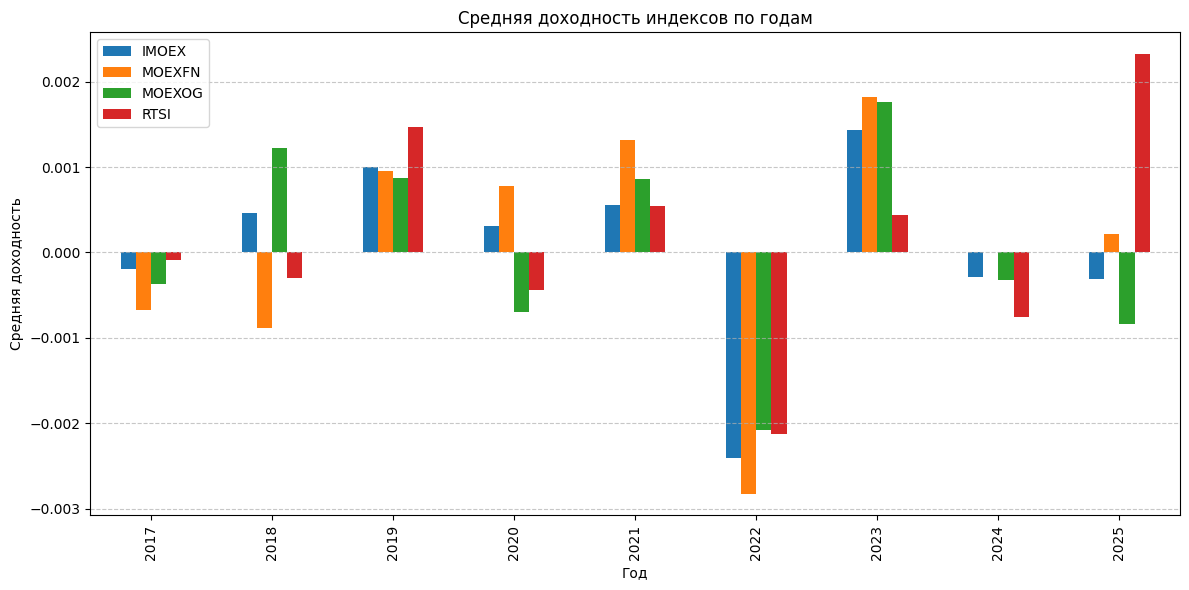

In [28]:
# Визуализация - Доходность индексов по годам
plt.figure(figsize=(12, 6))
indices_yearly_return = indices_df.groupby(['year', 'label'])['return'].mean().unstack()
indices_yearly_return.plot(kind='bar', ax=plt.gca())
plt.title('Средняя доходность индексов по годам')
plt.xlabel('Год')
plt.ylabel('Средняя доходность')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(['IMOEX', 'MOEXFN', 'MOEXOG', 'RTSI'])
plt.tight_layout()
plt.show()

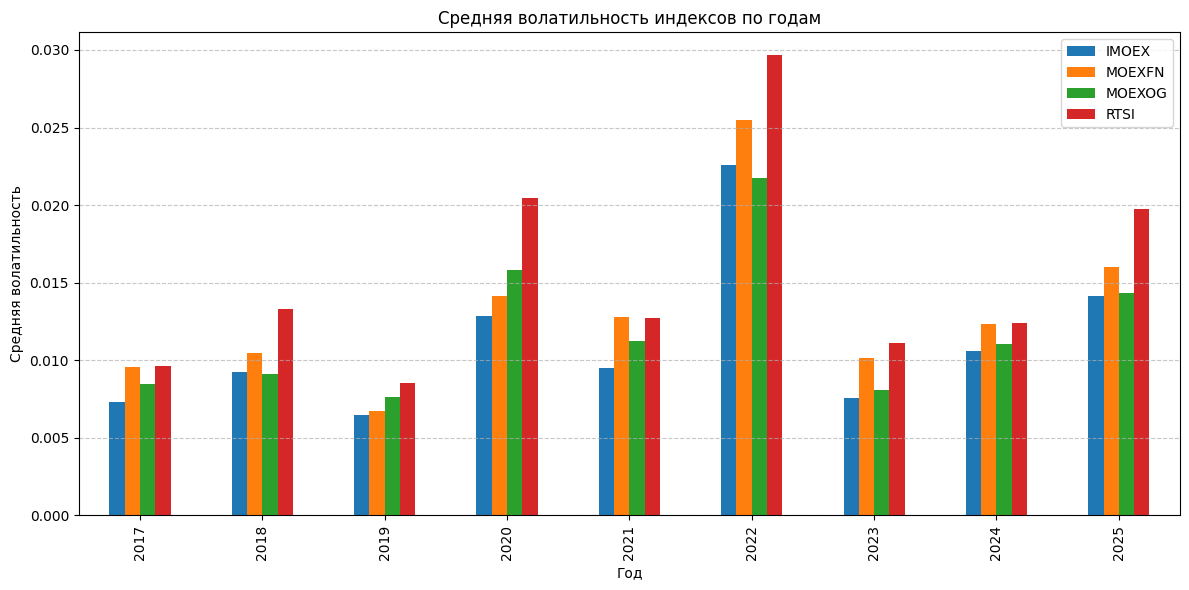

In [29]:
# Визуализация - Волатильность индексов по годам
plt.figure(figsize=(12, 6))
indices_yearly_vol = indices_df.groupby(['year', 'label'])['volatility_5d'].mean().unstack()
indices_yearly_vol.plot(kind='bar', ax=plt.gca())
plt.title('Средняя волатильность индексов по годам')
plt.xlabel('Год')
plt.ylabel('Средняя волатильность')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(['IMOEX', 'MOEXFN', 'MOEXOG', 'RTSI'])
plt.tight_layout()
plt.show()

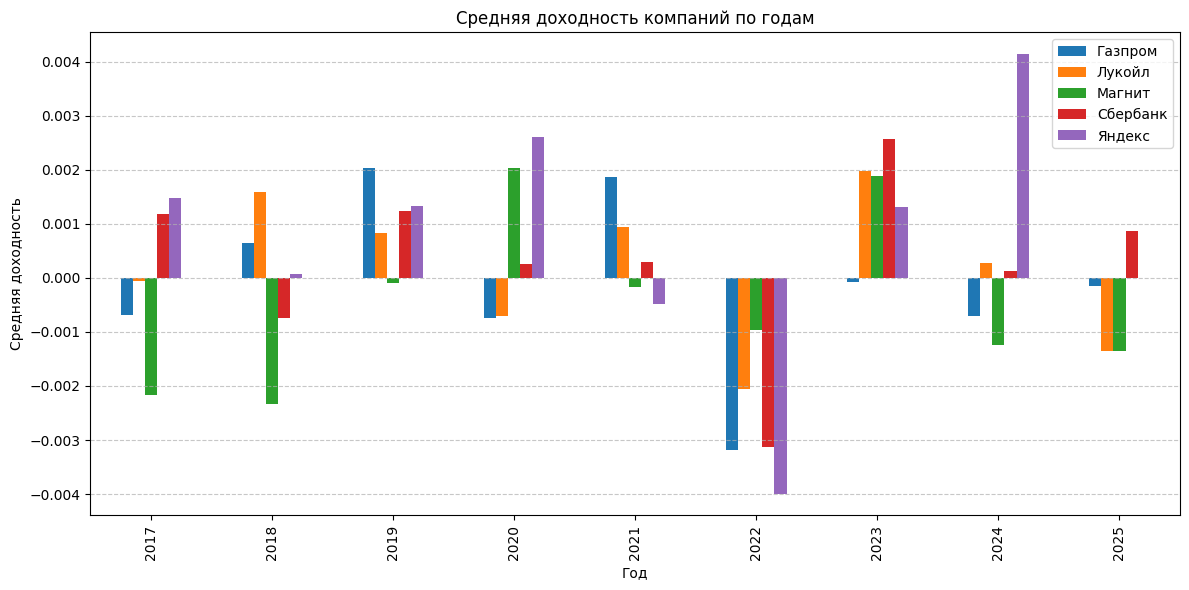

In [30]:
# Визуализация - Доходность компаний по годам
plt.figure(figsize=(12, 6))
companies_yearly_return = companies_df.groupby(['year', 'label'])['return'].mean().unstack()
companies_yearly_return.plot(kind='bar', ax=plt.gca())
plt.title('Средняя доходность компаний по годам')
plt.xlabel('Год')
plt.ylabel('Средняя доходность')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(['Газпром', 'Лукойл', 'Магнит', 'Сбербанк', 'Яндекс'])
plt.tight_layout()
plt.show()

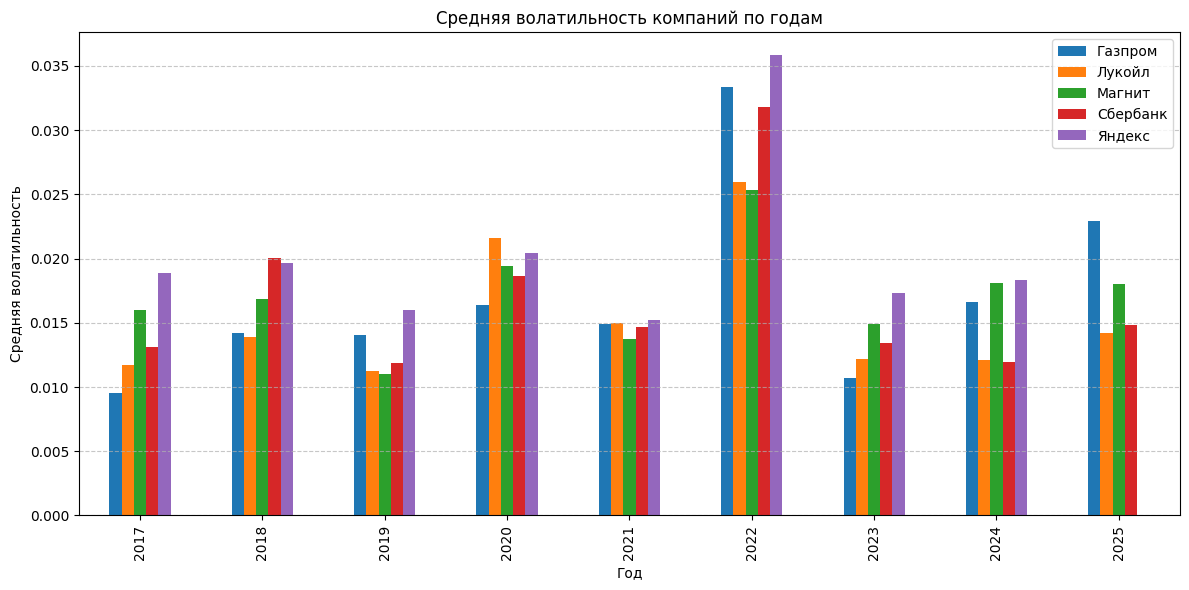

In [31]:
# Визуализация - Волатильность компаний по годам
plt.figure(figsize=(12, 6))
companies_yearly_vol = companies_df.groupby(['year', 'label'])['volatility_5d'].mean().unstack()
companies_yearly_vol.plot(kind='bar', ax=plt.gca())
plt.title('Средняя волатильность компаний по годам')
plt.xlabel('Год')
plt.ylabel('Средняя волатильность')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(['Газпром', 'Лукойл', 'Магнит', 'Сбербанк', 'Яндекс'])
plt.tight_layout()
plt.show()

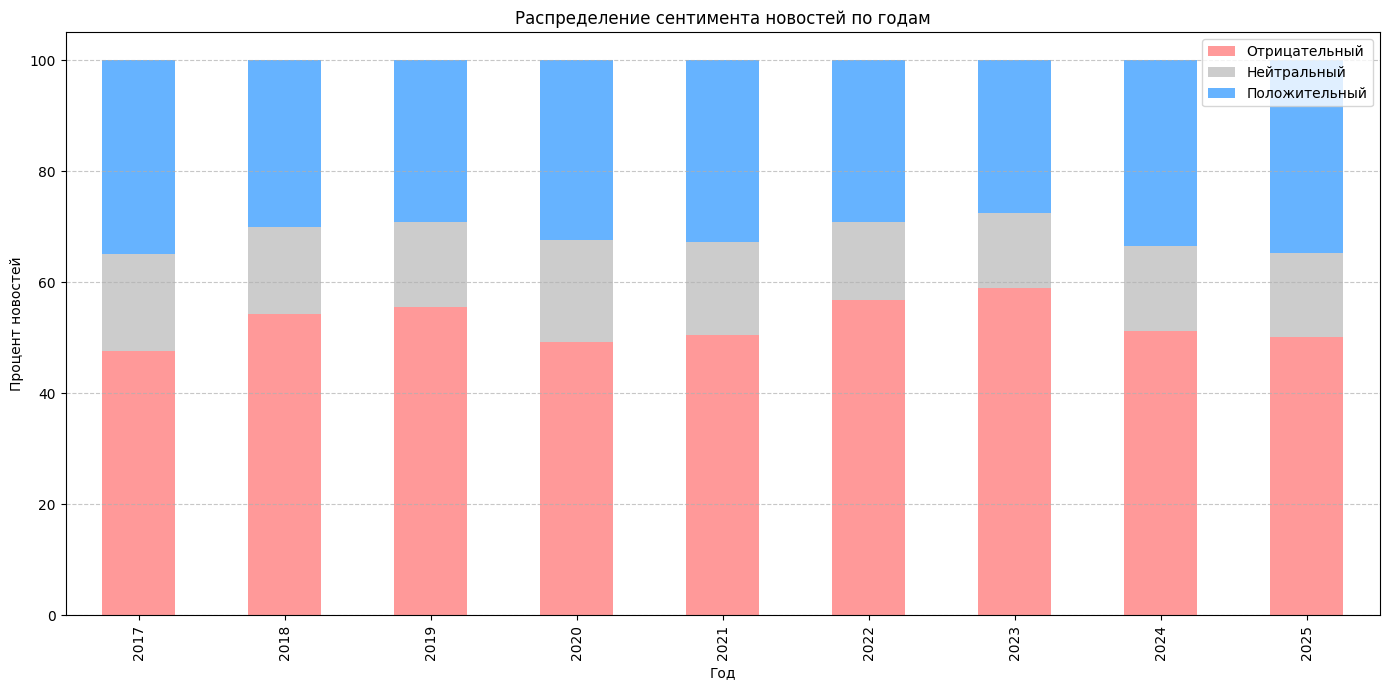

In [32]:
# Визуализация - Распределение сентимента новостей по годам
plt.figure(figsize=(14, 7))
sentiment_data = news_df.groupby('year').agg(
    negative=('count_negative', 'sum'),
    neutral=('count_neutral', 'sum'),
    positive=('count_positive', 'sum')
)
sentiment_pct = sentiment_data.div(sentiment_data.sum(axis=1), axis=0) * 100
sentiment_pct.plot(kind='bar', stacked=True, ax=plt.gca(), 
                  color=['#ff9999', '#cccccc', '#66b3ff'])
plt.title('Распределение сентимента новостей по годам')
plt.xlabel('Год')
plt.ylabel('Процент новостей')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(['Отрицательный', 'Нейтральный', 'Положительный'])
plt.tight_layout()
plt.show()

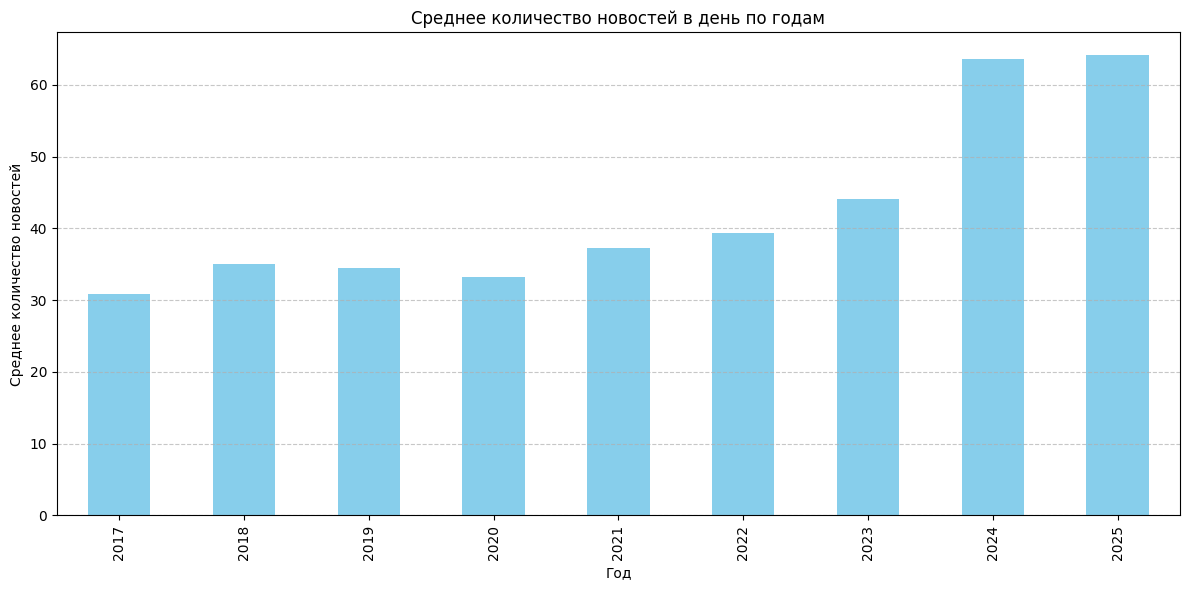

In [33]:
# Визуализация - Среднее количество новостей в день по годам
plt.figure(figsize=(12, 6))
avg_news_by_year = news_df.groupby('year')['total_news'].mean()
avg_news_by_year.plot(kind='bar', ax=plt.gca(), color='skyblue')
plt.title('Среднее количество новостей в день по годам')
plt.xlabel('Год')
plt.ylabel('Среднее количество новостей')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

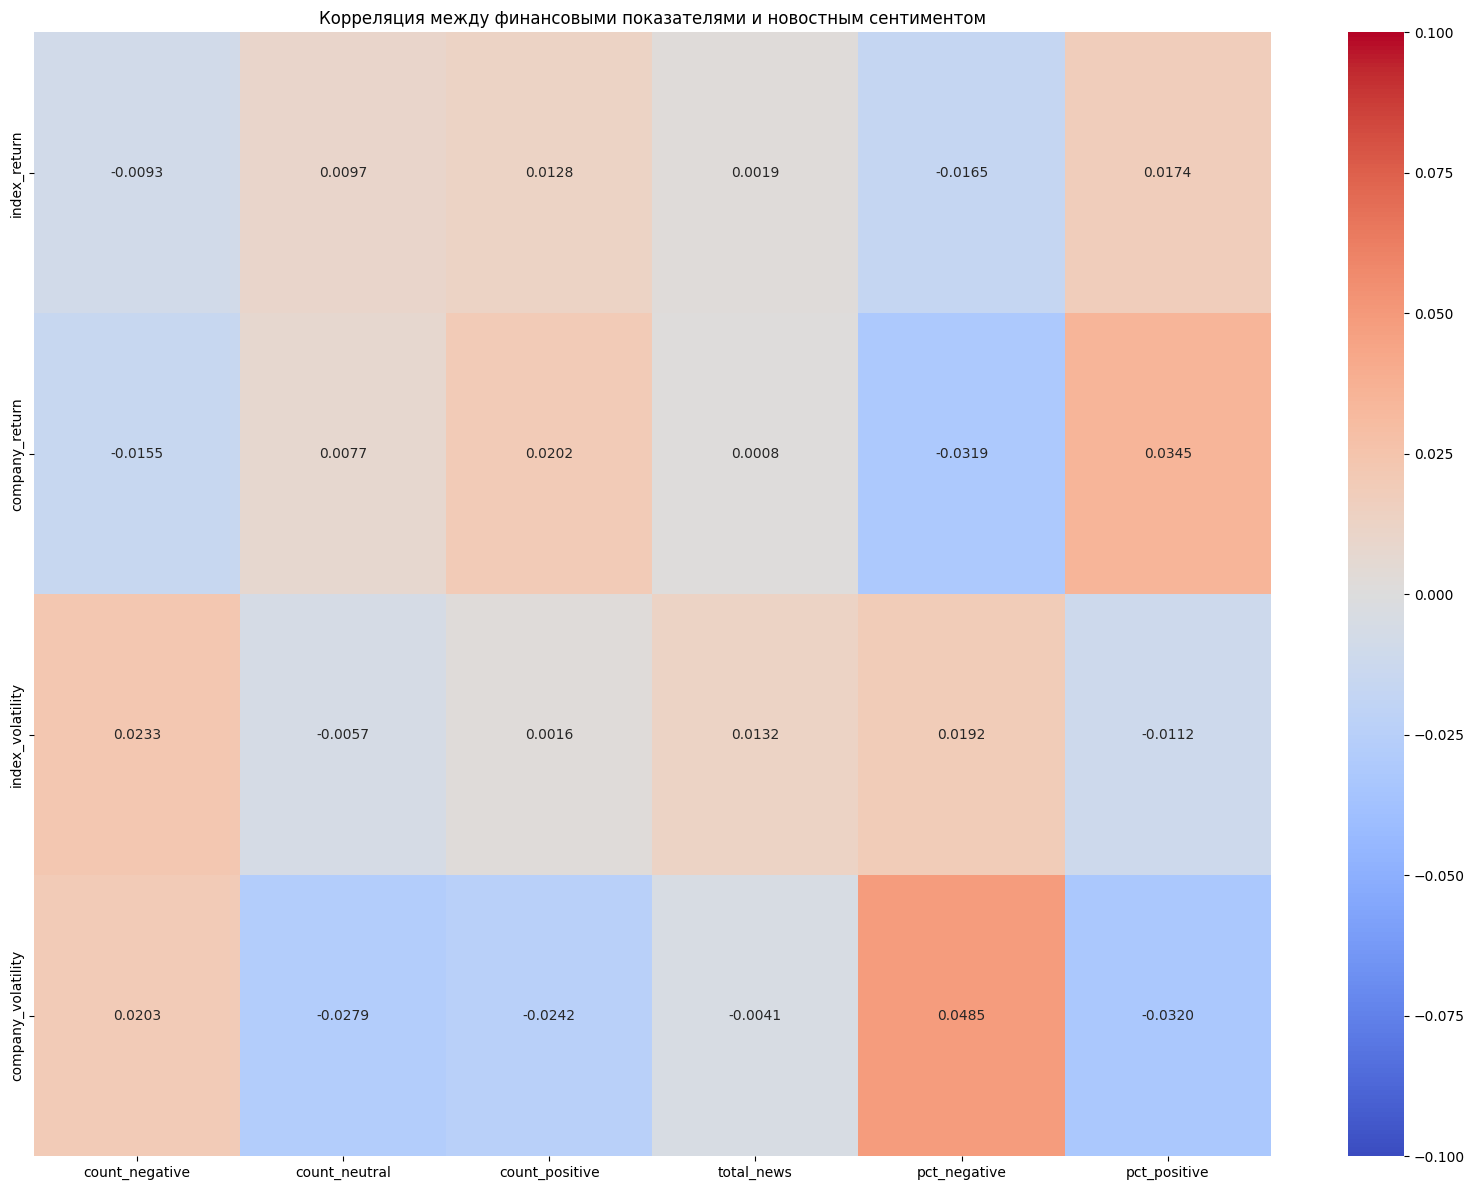

In [34]:
# Визуализация - Корреляционная HeatMap (тепловая карта)
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_subset, annot=True, cmap='coolwarm', vmin=-0.1, vmax=0.1, center=0, fmt='.4f')
plt.title('Корреляция между финансовыми показателями и новостным сентиментом')
plt.tight_layout()
plt.show()

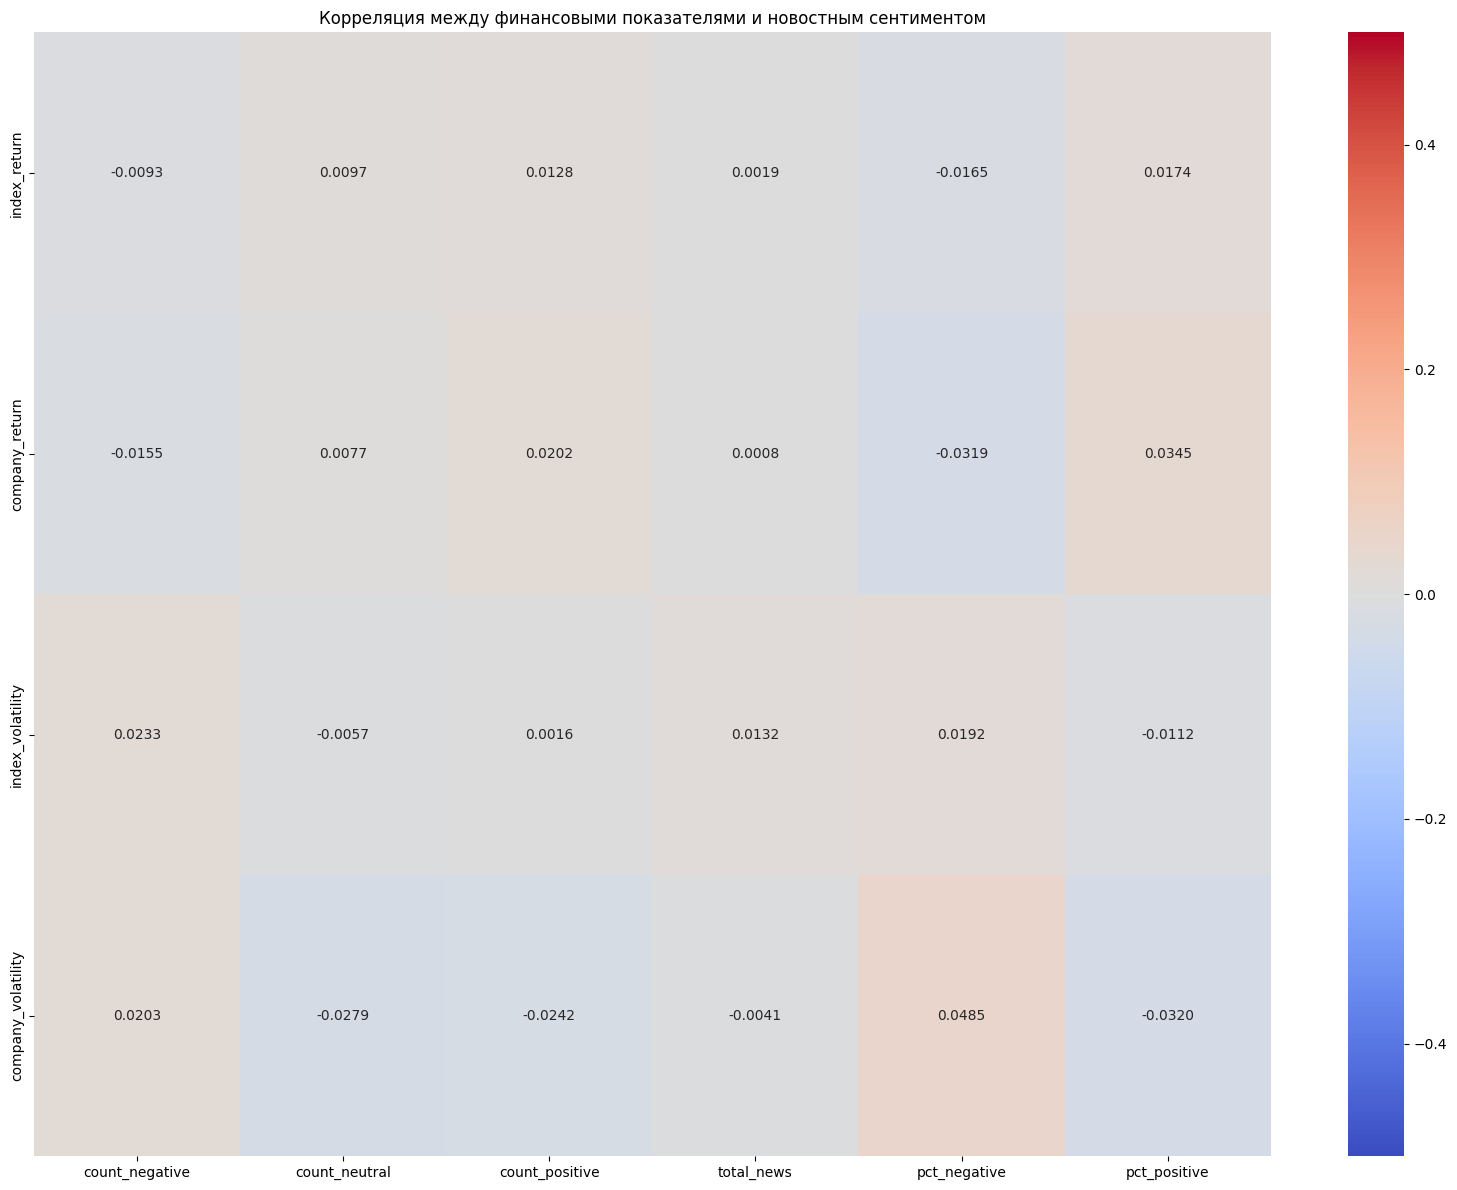

In [35]:
# Визуализация - Корреляционная HeatMap (тепловая карта)
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_subset, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5, center=0, fmt='.4f')
plt.title('Корреляция между финансовыми показателями и новостным сентиментом')
plt.tight_layout()
plt.show()

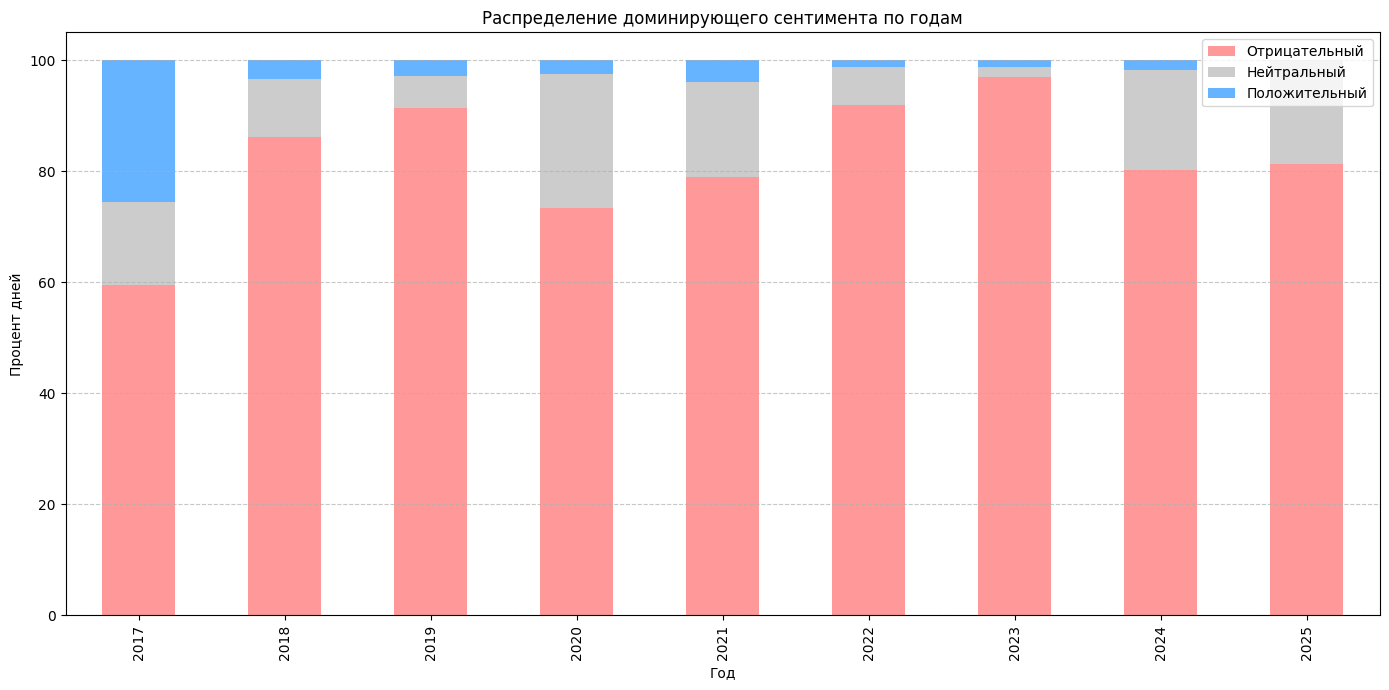

In [36]:
# Визуализация - Распределение доминирующего сентимента по годам
plt.figure(figsize=(14, 7))
dominant_sentiment = pd.crosstab(news_df['year'], news_df['dominant_sentiment'])
dominant_sentiment_pct = dominant_sentiment.div(dominant_sentiment.sum(axis=1), axis=0) * 100
dominant_sentiment_pct.plot(kind='bar', stacked=True, ax=plt.gca(),
                           color=['#ff9999', '#cccccc', '#66b3ff'])
plt.title('Распределение доминирующего сентимента по годам')
plt.xlabel('Год')
plt.ylabel('Процент дней')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(['Отрицательный', 'Нейтральный', 'Положительный'])
plt.tight_layout()
plt.show()

In [37]:
# Подготовка данных для анализа влияния категорий
# Получаем список всех столбцов категорий новостей
category_columns = [col for col in news_df.columns if col.startswith('count_') and 
                    col not in ['count_negative', 'count_neutral', 'count_positive']]


In [38]:
# Вывод списка категорий
categories = [col.replace('count_', '') for col in category_columns]
print("Список категорий новостей:")
for i, category in enumerate(categories, 1):
    print(f"{i}. {category}")

Список категорий новостей:
1. Бизнес
2. Здравоохранение
3. Культура и искусство
4. Локальные UK-новости
5. Медиа и СМИ
6. Мировые новости
7. Наука и природа
8. Образование
9. Погода и окружающая среда
10. Политические
11. Прочее
12. Спортивные
13. Технологические


In [39]:
# Создаем DataFrame с суммарной статистикой по категориям
categories_summary = pd.DataFrame()
for col in category_columns:
    category_name = col.replace('count_', '')
    categories_summary.loc[category_name, 'Общее количество'] = news_df[col].sum()
    categories_summary.loc[category_name, 'Среднее в день'] = news_df[col].mean()
    categories_summary.loc[category_name, 'Медиана в день'] = news_df[col].median()
    categories_summary.loc[category_name, 'Максимум в день'] = news_df[col].max()
    

In [40]:
categories_summary

,Общее количество,Среднее в день,Медиана в день,Максимум в день
Бизнес,7397.0,2.835186,3.0,14.0
Здравоохранение,2408.0,0.922959,1.0,7.0
Культура и искусство,4860.0,1.862783,2.0,12.0
Локальные UK-новости,33695.0,12.914910,13.0,47.0
Медиа и СМИ,13077.0,5.012265,0.0,82.0
Мировые новости,18274.0,7.004216,6.0,34.0
Наука и природа,1640.0,0.628593,0.0,9.0
Образование,1049.0,0.402070,0.0,5.0
Погода и окружающая среда,43.0,0.016481,0.0,2.0
Политические,7952.0,3.047911,3.0,23.0


In [41]:
# Добавляем процент от общего количества
total_news_by_category = categories_summary['Общее количество'].sum()
categories_summary['Процент от общего'] = categories_summary['Общее количество'] / total_news_by_category * 100

categories_summary

,Общее количество,Среднее в день,Медиана в день,Максимум в день,Процент от общего
Бизнес,7397.0,2.835186,3.0,14.0,7.063396
Здравоохранение,2408.0,0.922959,1.0,7.0,2.299399
Культура и искусство,4860.0,1.862783,2.0,12.0,4.640814
Локальные UK-новости,33695.0,12.914910,13.0,47.0,32.175358
Медиа и СМИ,13077.0,5.012265,0.0,82.0,12.487228
Мировые новости,18274.0,7.004216,6.0,34.0,17.449844
Наука и природа,1640.0,0.628593,0.0,9.0,1.566036
Образование,1049.0,0.402070,0.0,5.0,1.001690
Погода и окружающая среда,43.0,0.016481,0.0,2.0,0.041061
Политические,7952.0,3.047911,3.0,23.0,7.593365


In [42]:
# Сортировка по общему количеству новостей
categories_summary = categories_summary.sort_values('Общее количество', ascending=False)

In [43]:
# Округление числовых значений для лучшей читаемости
categories_summary = categories_summary.round({'Среднее в день': 2, 'Процент от общего': 2})

print("Статистика по категориям новостей:")
categories_summary
#categories_summary.drop('% Процент от общего', axis= 1)

Статистика по категориям новостей:


,Общее количество,Среднее в день,Медиана в день,Максимум в день,Процент от общего
Локальные UK-новости,33695.0,12.91,13.0,47.0,32.18
Мировые новости,18274.0,7.00,6.0,34.0,17.45
Медиа и СМИ,13077.0,5.01,0.0,82.0,12.49
Спортивные,10958.0,4.20,2.0,35.0,10.46
Политические,7952.0,3.05,3.0,23.0,7.59
Бизнес,7397.0,2.84,3.0,14.0,7.06
Культура и искусство,4860.0,1.86,2.0,12.0,4.64
Здравоохранение,2408.0,0.92,1.0,7.0,2.30
Технологические,1868.0,0.72,0.0,8.0,1.78
Наука и природа,1640.0,0.63,0.0,9.0,1.57


In [44]:
# Анализ категорий новостей по годам
# Создаем DataFrame для хранения данных по годам
categories_by_year = pd.DataFrame()

# Расчет среднего количества новостей каждой категории по годам
for col in category_columns:
    category_name = col.replace('count_', '')
    yearly_avg = news_df.groupby('year')[col].mean()
    categories_by_year[category_name] = yearly_avg

print("Среднее количество новостей по категориям и годам:")
categories_by_year

Среднее количество новостей по категориям и годам:


,Бизнес,Здравоохранение,Культура и искусство,Локальные UK-новости,Медиа и СМИ,Мировые новости,Наука и природа,Образование,Погода и окружающая среда,Политические,Прочее,Спортивные,Технологические
year,,,,,,,,,,,,,
2017,2.472222,0.753086,2.450617,7.888889,0.898148,6.429012,0.388889,0.361111,0.012346,2.253086,0.314815,5.891975,0.682099
2018,3.144654,1.103774,2.022013,12.371069,0.704403,7.201258,0.591195,0.550314,0.006289,3.119497,0.279874,3.050314,0.930818
2019,3.138889,0.753086,1.666667,13.916667,0.543210,5.503086,0.558642,0.537037,0.009259,4.336420,0.280864,2.385802,0.796296
2020,3.408669,1.198142,1.727554,14.321981,0.275542,5.089783,0.693498,0.671827,0.000000,3.058824,0.201238,1.597523,0.922601
2021,3.287926,1.294118,1.585139,17.222910,0.241486,5.696594,0.804954,0.458204,0.009288,3.068111,0.164087,2.715170,0.770898
2022,3.438710,0.996774,1.845161,15.341935,0.190323,9.225806,0.880645,0.229032,0.006452,3.645161,0.219355,2.761290,0.616129
2023,3.024922,1.059190,2.507788,17.062305,0.221184,11.691589,0.766355,0.376947,0.021807,3.694704,0.230530,2.588785,0.831776
2024,1.134731,0.344311,1.302395,6.799401,31.622754,6.047904,0.425150,0.077844,0.053892,1.586826,2.526946,11.455090,0.263473
2025,0.000000,0.000000,0.031250,0.093750,47.718750,0.031250,0.000000,0.000000,0.125000,0.000000,3.625000,12.500000,0.000000


In [45]:
# Процентное соотношение категорий по годам
# Создаем DataFrame для процентного соотношения
categories_pct_by_year = pd.DataFrame()

# Расчет годовых сумм по категориям
yearly_category_sums = news_df.groupby('year')[category_columns].sum()

# Рассчитываем процентное соотношение для каждой категории по годам
for col in category_columns:
    category_name = col.replace('count_', '')
    # Расчет общего количества новостей по категориям за каждый год
    yearly_totals = yearly_category_sums.sum(axis=1)
    # Расчет процентного соотношения
    categories_pct_by_year[category_name] = yearly_category_sums[col] / yearly_totals * 100

print("Процентное соотношение категорий новостей по годам:")
categories_pct_by_year.round(2)

Процентное соотношение категорий новостей по годам:


,Бизнес,Здравоохранение,Культура и искусство,Локальные UK-новости,Медиа и СМИ,Мировые новости,Наука и природа,Образование,Погода и окружающая среда,Политические,Прочее,Спортивные,Технологические
year,,,,,,,,,,,,,
2017,8.03,2.45,7.96,25.62,2.92,20.88,1.26,1.17,0.04,7.32,1.02,19.13,2.21
2018,8.97,3.15,5.76,35.27,2.01,20.53,1.69,1.57,0.02,8.89,0.80,8.70,2.65
2019,9.12,2.19,4.84,40.42,1.58,15.99,1.62,1.56,0.03,12.60,0.82,6.93,2.31
2020,10.28,3.61,5.21,43.18,0.83,15.35,2.09,2.03,0.00,9.22,0.61,4.82,2.78
2021,8.81,3.47,4.25,46.15,0.65,15.26,2.16,1.23,0.02,8.22,0.44,7.28,2.07
2022,8.73,2.53,4.68,38.94,0.48,23.42,2.24,0.58,0.02,9.25,0.56,7.01,1.56
2023,6.86,2.40,5.69,38.71,0.50,26.52,1.74,0.86,0.05,8.38,0.52,5.87,1.89
2024,1.78,0.54,2.05,10.68,49.69,9.50,0.67,0.12,0.08,2.49,3.97,18.00,0.41
2025,0.00,0.00,0.05,0.15,74.42,0.05,0.00,0.00,0.19,0.00,5.65,19.49,0.00


In [46]:
# Корреляция между категориями новостей и финансовыми показателями
# Объединяем данные о категориях с финансовыми данными
category_finance_df = merged_data.copy()

# Добавляем столбцы с категориями
for col in category_columns:
    category_name = col.replace('count_', '')
    category_finance_df[category_name] = news_df[col]

# Выбираем столбцы для корреляционного анализа
financial_columns = ['index_return', 'company_return', 'index_volatility', 'company_volatility']
category_names = [col.replace('count_', '') for col in category_columns]

# Расчет корреляций между категориями и финансовыми показателями
category_finance_corr = category_finance_df[financial_columns + category_names].corr() #По умолчанию вычисляется корреляция Пирсона

# Выбираем подмножество для более понятного представления
category_corr_subset = category_finance_corr.loc[financial_columns, category_names]

print("Корреляция между категориями новостей и финансовыми показателями:")
category_corr_subset.round(4)

Корреляция между категориями новостей и финансовыми показателями:


,Бизнес,Здравоохранение,Культура и искусство,Локальные UK-новости,Медиа и СМИ,Мировые новости,Наука и природа,Образование,Погода и окружающая среда,Политические,Прочее,Спортивные,Технологические
index_return,0.0026,-0.0334,-0.0075,0.0016,-0.0113,0.0088,-0.0110,-0.0293,0.0134,0.0256,0.0042,0.0042,-0.0431
company_return,0.0174,-0.0227,-0.0285,0.0059,-0.0027,-0.0029,-0.0129,-0.0229,0.0212,0.0309,-0.0110,0.0145,-0.0469
index_volatility,0.0436,0.0069,-0.0120,0.1084,-0.0414,-0.0303,0.0208,0.0653,-0.0095,0.0673,-0.0402,-0.0706,0.0506
company_volatility,0.0321,0.0228,-0.0063,0.1002,-0.0313,-0.0242,0.0077,0.0635,-0.0041,0.0470,-0.0359,-0.0831,0.0555


In [47]:
# Корреляция между категориями новостей и финансовыми показателями
# Подготавливаем данные: объединяем по дате финансовые показатели и категории новостей
# Переименуем столбец в news_df для правильного соединения
news_categories = news_df.copy()

# Выбираем только категории и дату
news_categories_cols = ['date'] + category_columns
news_categories = news_categories[news_categories_cols]

# Объединяем с финансовыми данными
category_finance_df = merged_data.merge(news_categories, on='date', how='inner')

# Выбираем столбцы для корреляционного анализа
financial_columns = ['index_return', 'company_return', 'index_volatility', 'company_volatility']
category_names = category_columns

# Расчет корреляций между категориями и финансовыми показателями
category_finance_corr = category_finance_df[financial_columns + category_names].corr() #По умолчанию вычисляется корреляция Пирсона

# Выбираем подмножество для более понятного представления
category_corr_subset = category_finance_corr.loc[financial_columns, category_names]

print("Корреляция между категориями новостей и финансовыми показателями:")
category_corr_subset.round(4)

Корреляция между категориями новостей и финансовыми показателями:


,count_Бизнес,count_Здравоохранение,count_Культура и искусство,count_Локальные UK-новости,count_Медиа и СМИ,count_Мировые новости,count_Наука и природа,count_Образование,count_Погода и окружающая среда,count_Политические,count_Прочее,count_Спортивные,count_Технологические
index_return,0.0556,0.0171,0.0073,-0.0013,-0.0067,-0.0170,0.0221,0.0402,0.0153,0.0066,-0.0118,-0.0127,0.0809
company_return,0.0424,-0.0009,0.0096,0.0006,-0.0069,-0.0172,0.0263,0.0351,0.0019,0.0100,-0.0137,-0.0086,0.0769
index_volatility,0.0229,0.0003,-0.0834,-0.0524,0.0639,-0.0494,0.0289,-0.0496,0.0073,-0.0680,0.0577,0.0034,-0.0433
company_volatility,0.0490,0.0126,-0.0624,-0.0426,0.0376,-0.0294,0.0255,-0.0404,0.0085,-0.0357,0.0333,-0.0299,-0.0363


In [48]:
from scipy.stats import pearsonr

# Словарь пар: категория новости — финансовый показатель
category_pairs = {
    'Бизнес vs index_return': ('count_Бизнес', 'index_return'),
    'Бизнес vs company_return': ('count_Бизнес', 'company_return'),
    'Бизнес vs index_volatility': ('count_Бизнес', 'index_volatility'),
    'Бизнес vs company_volatility': ('count_Бизнес', 'company_volatility'),
    
    'Политика vs index_return': ('count_Политические', 'index_return'),
    'Политика vs company_return': ('count_Политические', 'company_return'),
    'Политика vs index_volatility': ('count_Политические', 'index_volatility'),
    'Политика vs company_volatility': ('count_Политические', 'company_volatility'),
    
    'Мировые vs index_return': ('count_Мировые новости', 'index_return'),
    'Мировые vs company_return': ('count_Мировые новости', 'company_return'),

    'Спорт vs index_return': ('count_Спортивные', 'index_return'),
    'Спорт vs company_return': ('count_Спортивные', 'company_return'),

    'Технологии vs index_return': ('count_Технологические', 'index_return'),
    'Технологии vs company_return': ('count_Технологические', 'company_return'),
}

# Сохраняем результаты
category_results = []

# Расчёт Пирсона для каждой пары
for name, (x_col, y_col) in category_pairs.items():
    corr, pval = pearsonr(category_finance_df[x_col], category_finance_df[y_col])
    category_results.append({
        'Пара': name,
        'Коэффициент Пирсона': round(corr, 4),
        'p-value': round(pval, 4)
    })

# Преобразуем в таблицу
pearson_categories_df = pd.DataFrame(category_results)
print(pearson_categories_df)


                              Пара  Коэффициент Пирсона  p-value
0           Бизнес vs index_return               0.0556   0.0192
1         Бизнес vs company_return               0.0424   0.0740
2       Бизнес vs index_volatility               0.0229   0.3354
3     Бизнес vs company_volatility               0.0490   0.0389
4         Политика vs index_return               0.0066   0.7819
5       Политика vs company_return               0.0100   0.6726
6     Политика vs index_volatility              -0.0680   0.0041
7   Политика vs company_volatility              -0.0357   0.1321
8          Мировые vs index_return              -0.0170   0.4752
9        Мировые vs company_return              -0.0172   0.4684
10           Спорт vs index_return              -0.0127   0.5932
11         Спорт vs company_return              -0.0086   0.7171
12      Технологии vs index_return               0.0809   0.0006
13    Технологии vs company_return               0.0769   0.0012


In [49]:
from scipy.stats import pearsonr
import pandas as pd

# Шаг 1. Находим все столбцы категорий новостей
category_columns = [col for col in category_finance_df.columns if col.startswith('count_') and 'negative' not in col and 'positive' not in col and 'neutral' not in col]

# Шаг 2. Финансовые метрики для анализа
financial_metrics = ['index_return', 'company_return', 'index_volatility', 'company_volatility']

# Шаг 3. Сохраняем результаты в список
results = []

for cat_col in category_columns:
    for fin_col in financial_metrics:
        # Формируем имя пары для читаемости (убираем 'count_')
        pair_name = f"{cat_col.replace('count_', '')} vs {fin_col}"
        
        # Расчёт Пирсона
        corr, pval = pearsonr(category_finance_df[cat_col], category_finance_df[fin_col])
        
        # Сохраняем результат
        results.append({
            'Пара': pair_name,
            'Коэффициент Пирсона': round(corr, 4),
            'p-value': round(pval, 4)
        })

# Шаг 4. Преобразуем результаты в таблицу
pearson_all_categories_df = pd.DataFrame(results)

# Шаг 5. Выводим результат
pearson_all_categories_df


,Пара,Коэффициент Пирсона,p-value
0,Бизнес vs index_return,0.0556,0.0192
1,Бизнес vs company_return,0.0424,0.0740
2,Бизнес vs index_volatility,0.0229,0.3354
3,Бизнес vs company_volatility,0.0490,0.0389
4,Здравоохранение vs index_return,0.0171,0.4712
5,Здравоохранение vs company_return,-0.0009,0.9712
6,Здравоохранение vs index_volatility,0.0003,0.9909
7,Здравоохранение vs company_volatility,0.0126,0.5966
8,Культура и искусство vs index_return,0.0073,0.7595
9,Культура и искусство vs company_return,0.0096,0.6865


In [50]:
# Отбор значимых связей (p-value < 0.05)
significant_corr = pearson_all_categories_df[pearson_all_categories_df['p-value'] < 0.05]

# Сортировка по p-value по возрастанию
significant_corr = significant_corr.sort_values('p-value')

# Вывод
print("Значимые корреляции категорий новостей с финансовыми показателями (p < 0.05):")
significant_corr


Значимые корреляции категорий новостей с финансовыми показателями (p < 0.05):


,Пара,Коэффициент Пирсона,p-value
10,Культура и искусство vs index_volatility,-0.0834,0.0004
48,Технологические vs index_return,0.0809,0.0006
49,Технологические vs company_return,0.0769,0.0012
38,Политические vs index_volatility,-0.0680,0.0041
18,Медиа и СМИ vs index_volatility,0.0639,0.0070
11,Культура и искусство vs company_volatility,-0.0624,0.0086
42,Прочее vs index_volatility,0.0577,0.0149
0,Бизнес vs index_return,0.0556,0.0192
14,Локальные UK-новости vs index_volatility,-0.0524,0.0273
30,Образование vs index_volatility,-0.0496,0.0364


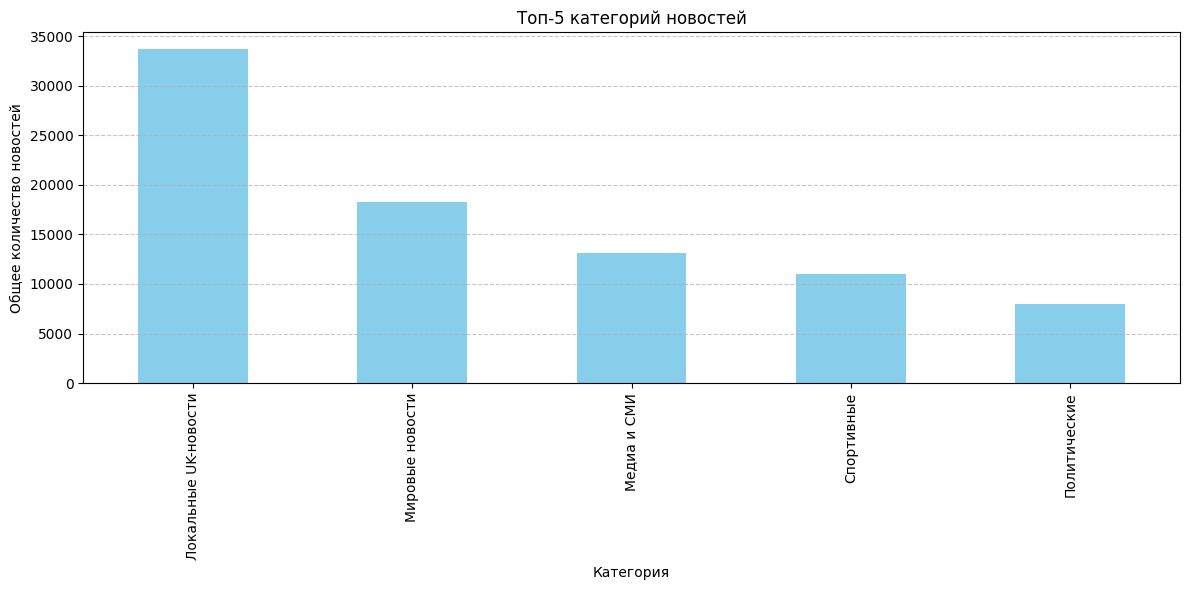

In [51]:
# Визуализация - Топ-5 категорий новостей
plt.figure(figsize=(12, 6))
top_categories = categories_summary.head(5)
top_categories['Общее количество'].plot(kind='bar', color='skyblue')
plt.title('Топ-5 категорий новостей')
plt.xlabel('Категория')
plt.ylabel('Общее количество новостей')
plt.xticks()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

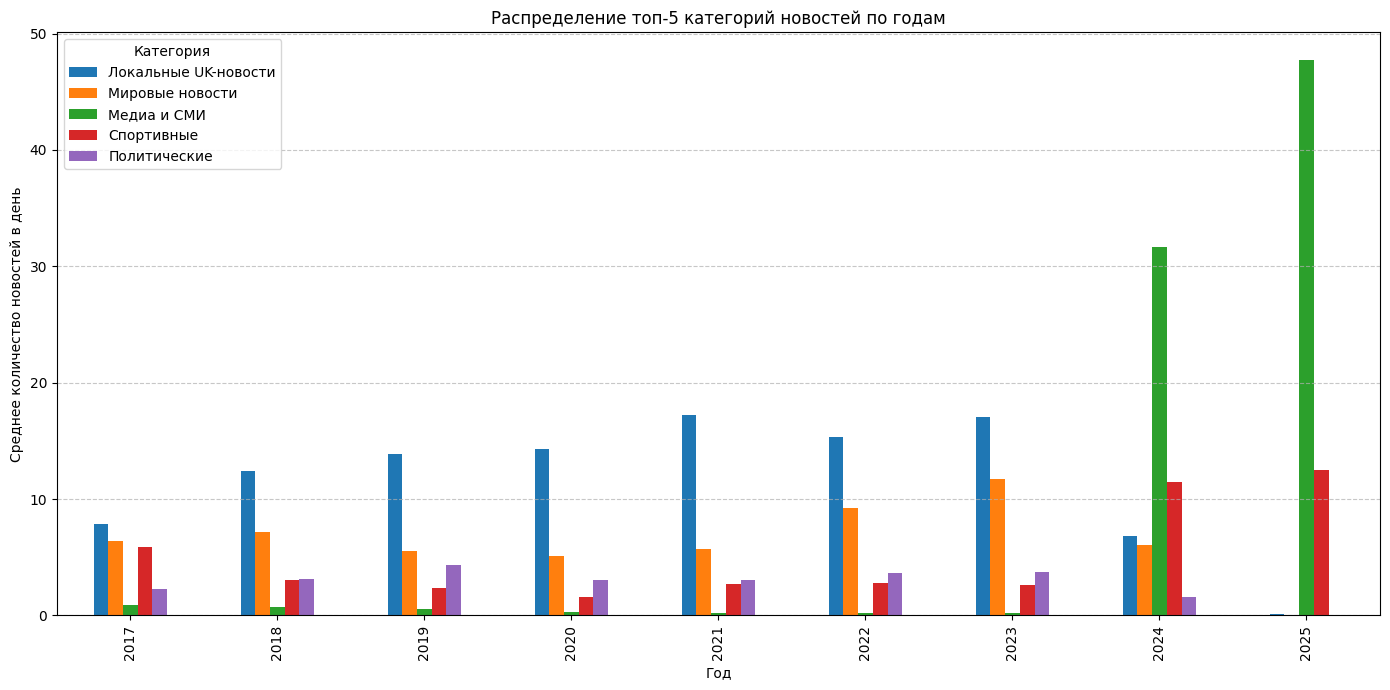

In [52]:
#  Визуализация - Распределение топ-5 категорий новостей по годам
plt.figure(figsize=(14, 7))
top_categories_names = categories_summary.head(5).index
categories_by_year[top_categories_names].plot(kind='bar', ax=plt.gca())
plt.title('Распределение топ-5 категорий новостей по годам')
plt.xlabel('Год')
plt.ylabel('Среднее количество новостей в день')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Категория')
plt.tight_layout()
plt.show()


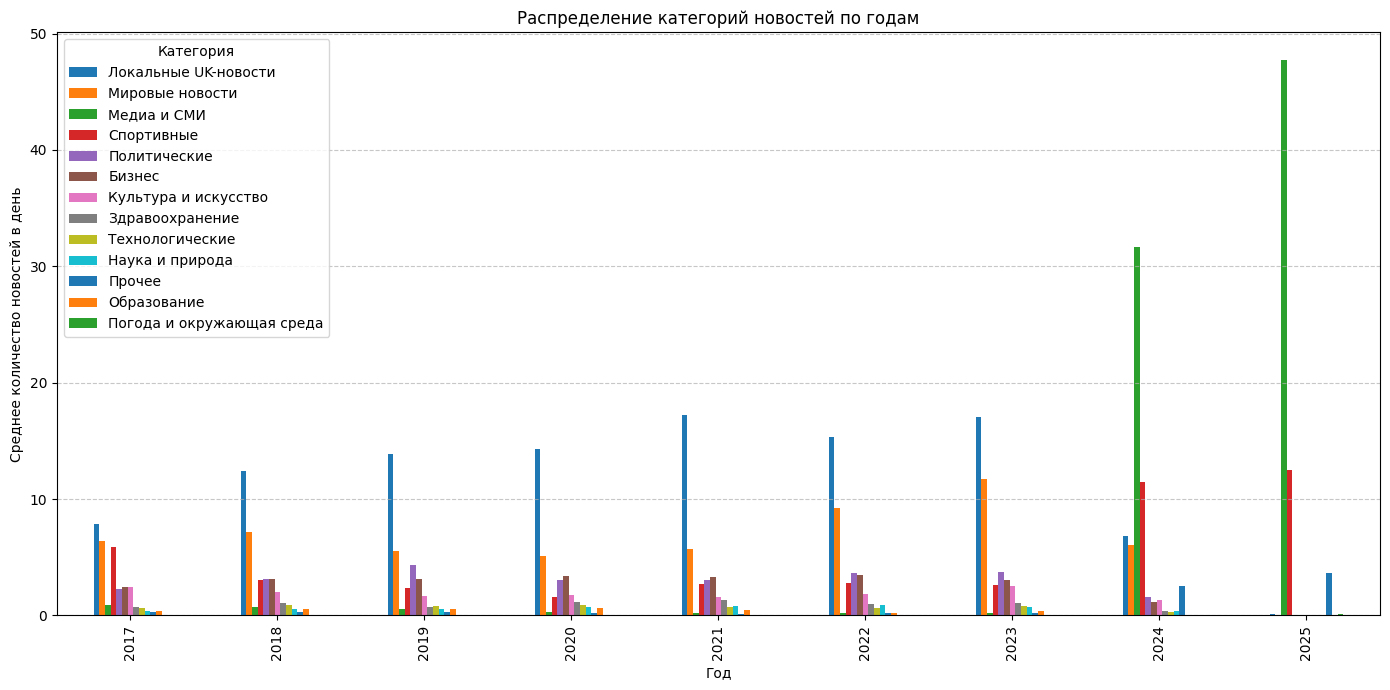

In [53]:
#  Визуализация - Распределение топ-5 категорий новостей по годам
plt.figure(figsize=(14, 7))
top_categories_names = categories_summary.index
categories_by_year[top_categories_names].plot(kind='bar', ax=plt.gca())
plt.title('Распределение категорий новостей по годам')
plt.xlabel('Год')
plt.ylabel('Среднее количество новостей в день')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Категория')
plt.tight_layout()
plt.show()

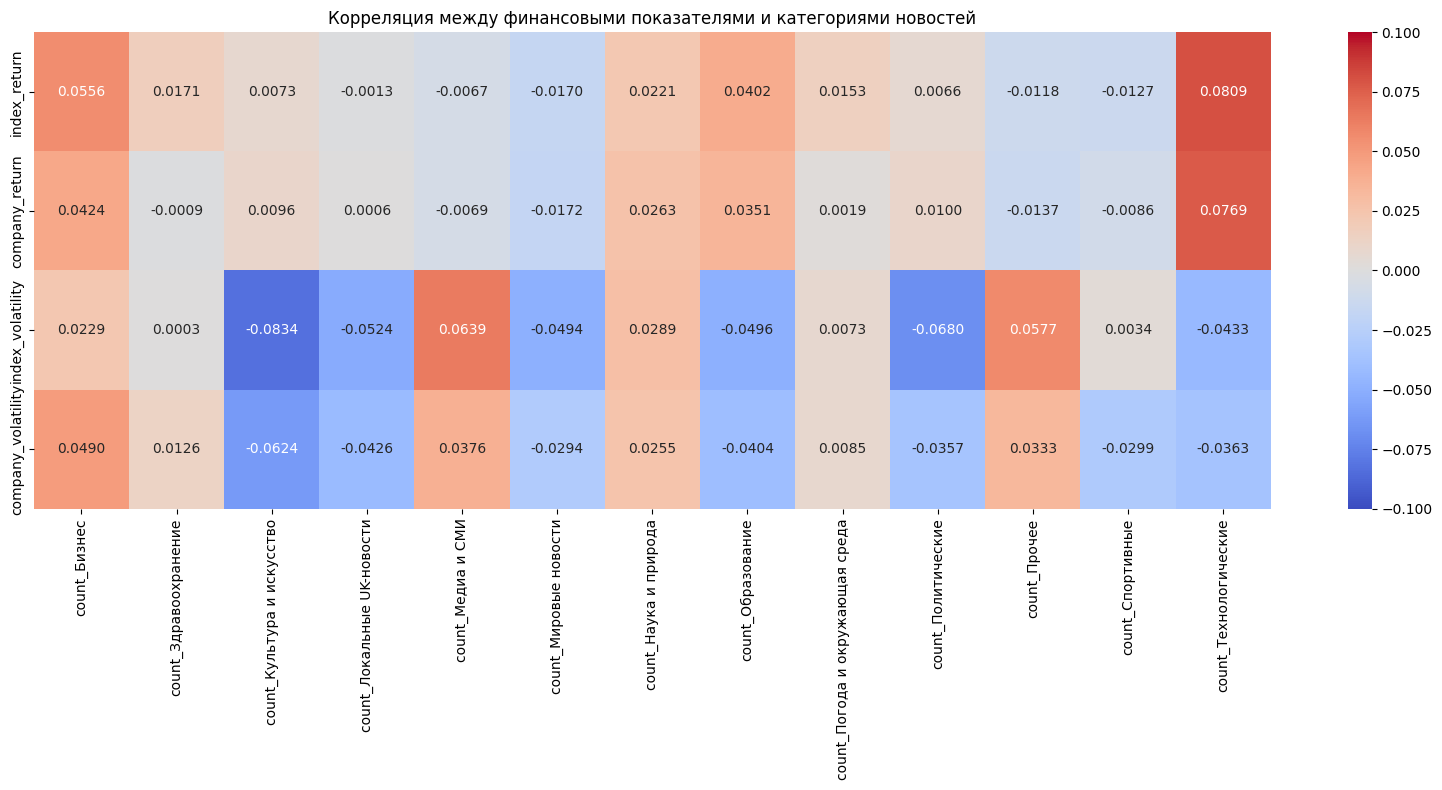

In [55]:
# Визуализация - Тепловая карта корреляций категорий и финансовых показателей
plt.figure(figsize=(16, 8))
sns.heatmap(category_corr_subset, annot=True, cmap='coolwarm', vmin=-0.1, vmax=0.1, center=0, fmt='.4f')
plt.title('Корреляция между финансовыми показателями и категориями новостей')
plt.tight_layout()
plt.show()


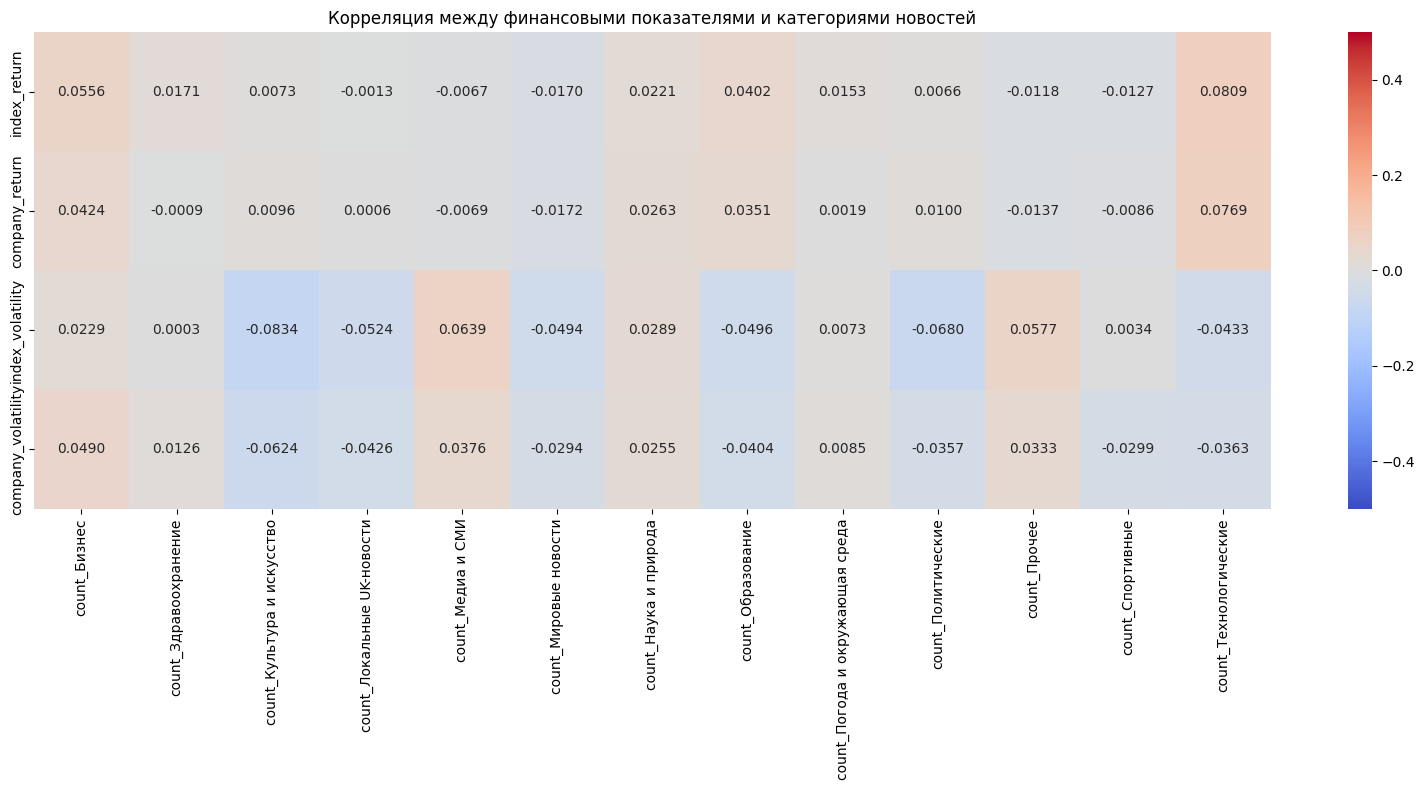

In [56]:
# Визуализация - Тепловая карта корреляций категорий и финансовых показателей
plt.figure(figsize=(16, 8))
sns.heatmap(category_corr_subset, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5, center=0, fmt='.4f')
plt.title('Корреляция между финансовыми показателями и категориями новостей')
plt.tight_layout()
plt.show()


**Тест на стационарность данных**

In [58]:
from statsmodels.tsa.stattools import adfuller

In [84]:
for name in ['index_return', 'company_return', 'index_volatility', 'company_volatility']:
    print(f"\n{name}")
    series = merged_data[name].dropna() # на всякий случай удаляем пропуски
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value:.4f}")



index_return
ADF Statistic: -8.0986
p-value: 0.0000
Critical Values:
   1%: -3.4341
   5%: -2.8632
   10%: -2.5676

company_return
ADF Statistic: -8.5401
p-value: 0.0000
Critical Values:
   1%: -3.4341
   5%: -2.8632
   10%: -2.5676

index_volatility
ADF Statistic: -5.1326
p-value: 0.0000
Critical Values:
   1%: -3.4341
   5%: -2.8632
   10%: -2.5676

company_volatility
ADF Statistic: -5.0889
p-value: 0.0000
Critical Values:
   1%: -3.4341
   5%: -2.8632
   10%: -2.5676


In [91]:
# 1. Список переменных
financial_columns = [
    'index_return', 'company_return', 
    'index_volatility', 'company_volatility'
]

# 2. Список для хранения результатов
financial_results = []

# 3. Проходим по каждой переменной
for var in financial_columns:
    series = category_finance_df[var].dropna()
    result = adfuller(series)

    adf_stat = round(result[0], 4)
    p_value = round(result[1], 4)
    is_stationary = "Да" if p_value < 0.05 else "Нет"

    financial_results.append({
        'Переменная': var,
        'ADF-статистика': adf_stat,
        'p-value': p_value,
        'Стационарен?': is_stationary
    })

# 4. Преобразуем в таблицу
financial_df = pd.DataFrame(financial_results)

In [92]:
financial_df

,Переменная,ADF-статистика,p-value,Стационарен?
0,index_return,-8.0986,0.0,Да
1,company_return,-8.5401,0.0,Да
2,index_volatility,-5.1326,0.0,Да
3,company_volatility,-5.0889,0.0,Да


In [87]:
# 1. Список категорий
category_columns = [
    col for col in category_finance_df.columns 
    if col.startswith('count_') and col not in ['count_negative', 'count_neutral', 'count_positive']
]

# 2. Список для хранения результатов
stationarity_results = []

# 3. Проходим по каждой категории
for category in category_columns:
    series = category_finance_df[category].dropna()
    result = adfuller(series)
    
    adf_stat = round(result[0], 4)
    p_value = round(result[1], 4)
    is_stationary = "Да" if p_value < 0.05 else "Нет"
    
    stationarity_results.append({
        'Категория': category.replace('count_', ''),
        'ADF-статистика': adf_stat,
        'p-value': p_value,
        'Стационарен?': is_stationary
    })

# 4. Преобразуем в таблицу
stationarity_df = pd.DataFrame(stationarity_results)



In [82]:
stationarity_df

,Категория,ADF-статистика,p-value,Стационарен?
0,Бизнес,-2.7651,0.0634,Нет
1,Здравоохранение,-4.3932,0.0003,Да
2,Культура и искусство,-4.5312,0.0002,Да
3,Локальные UK-новости,-1.8787,0.3421,Нет
4,Медиа и СМИ,-0.6160,0.8673,Нет
5,Мировые новости,-2.9046,0.0448,Да
6,Наука и природа,-4.3603,0.0003,Да
7,Образование,-4.0650,0.0011,Да
8,Погода и окружающая среда,-21.3924,0.0000,Да
9,Политические,-5.1813,0.0000,Да


In [88]:
# 1. Переменные сентимента
sentiment_columns = [
    'count_negative', 'count_neutral', 'count_positive',
    'pct_negative', 'pct_neutral', 'pct_positive'
]

# 2. Список для хранения результатов
sentiment_results = []

# 3. Проходим по каждой переменной
for col in sentiment_columns:
    if col in category_finance_df.columns:
        series = category_finance_df[col].dropna()
        result = adfuller(series)
        
        adf_stat = round(result[0], 4)
        p_value = round(result[1], 4)
        is_stationary = "Да" if p_value < 0.05 else "Нет"
        
        sentiment_results.append({
            'Сентимент': col,
            'ADF-статистика': adf_stat,
            'p-value': p_value,
            'Стационарен?': is_stationary
        })

# 4. Преобразуем в таблицу
sentiment_df = pd.DataFrame(sentiment_results)

In [89]:
sentiment_df

,Сентимент,ADF-статистика,p-value,Стационарен?
0,count_negative,-3.0414,0.0312,Да
1,count_neutral,-4.8532,0.0000,Да
2,count_positive,-4.8760,0.0000,Да
3,pct_negative,-4.9003,0.0000,Да
4,pct_neutral,-5.9876,0.0000,Да
5,pct_positive,-6.0281,0.0000,Да


**Granger casuality test**

In [60]:
from statsmodels.tsa.stattools import grangercausalitytests

In [61]:
# Оставляем только нужные столбцы
df_gc = merged_data[['index_return', 'count_negative']].dropna()

# Тест Грейнджера: проверяем, вызывает ли count_negative переменную index_return
grangercausalitytests(df_gc, maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3786  , p=0.5384  , df_denom=1772, df_num=1
ssr based chi2 test:   chi2=0.3793  , p=0.5380  , df=1
likelihood ratio test: chi2=0.3792  , p=0.5380  , df=1
parameter F test:         F=0.3786  , p=0.5384  , df_denom=1772, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7197  , p=0.4870  , df_denom=1769, df_num=2
ssr based chi2 test:   chi2=1.4435  , p=0.4859  , df=2
likelihood ratio test: chi2=1.4429  , p=0.4861  , df=2
parameter F test:         F=0.7197  , p=0.4870  , df_denom=1769, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5666  , p=0.6370  , df_denom=1766, df_num=3
ssr based chi2 test:   chi2=1.7067  , p=0.6355  , df=3
likelihood ratio test: chi2=1.7059  , p=0.6356  , df=3
parameter F test:         F=0.5666  , p=0.6370  , df_denom=1766, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5343  , p=0.

{1: ({'ssr_ftest': (0.3786331655917458, 0.5384146677839916, 1772.0, 1),
   'ssr_chi2test': (0.3792741923957951, 0.5379919324414872, 1),
   'lrtest': (0.37923367734583735, 0.5380136448225019, 1),
   'params_ftest': (0.37863316559158045, 0.5384146677840973, 1772.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.7197029094380796, 0.48703939641439276, 1769.0, 2),
   'ssr_chi2test': (1.4434742355490708, 0.4859074439457719, 2),
   'lrtest': (1.4428872884545854, 0.48605006585383337, 2),
   'params_ftest': (0.7197029094387859, 0.48703939641405725, 1769.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.566644422741777, 0.6370234988675021, 1766.0, 3),
   'ssr_chi2test': (1.706671395562577, 0.6354516116211655, 3),
   'lrtest': (1.705850510219534, 0.6356338775249761, 3),
   'params_ftest': (0.5666444227421938, 0.6370234988671968, 1766.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 

In [101]:
# 1. Новости -> доходность индекса
grangercausalitytests(merged_data[['index_return', 'count_negative']].dropna(), maxlag=5)

# 2. Новости -> волатильность компаний
grangercausalitytests(merged_data[['company_volatility', 'count_negative']].dropna(), maxlag=5)

# 3. Позитивные новости -> доходность компаний
grangercausalitytests(merged_data[['company_return', 'count_positive']].dropna(), maxlag=5)

# И наоборот:
# Доходность -> новости (для исключения обратной причинности)
grangercausalitytests(merged_data[['count_negative', 'index_return']].dropna(), maxlag=5)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3786  , p=0.5384  , df_denom=1772, df_num=1
ssr based chi2 test:   chi2=0.3793  , p=0.5380  , df=1
likelihood ratio test: chi2=0.3792  , p=0.5380  , df=1
parameter F test:         F=0.3786  , p=0.5384  , df_denom=1772, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7197  , p=0.4870  , df_denom=1769, df_num=2
ssr based chi2 test:   chi2=1.4435  , p=0.4859  , df=2
likelihood ratio test: chi2=1.4429  , p=0.4861  , df=2
parameter F test:         F=0.7197  , p=0.4870  , df_denom=1769, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5666  , p=0.6370  , df_denom=1766, df_num=3
ssr based chi2 test:   chi2=1.7067  , p=0.6355  , df=3
likelihood ratio test: chi2=1.7059  , p=0.6356  , df=3
parameter F test:         F=0.5666  , p=0.6370  , df_denom=1766, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5343  , p=0.

{1: ({'ssr_ftest': (0.06479897623286106, 0.7990952511807987, 1772.0, 1),
   'ssr_chi2test': (0.06490868104589638, 0.7988993403967889, 1),
   'lrtest': (0.06490749427575793, 0.7989011394029749, 1),
   'params_ftest': (0.06479897623287217, 0.7990952511807987, 1772.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.2583878319872588, 0.7723247953376294, 1769.0, 2),
   'ssr_chi2test': (0.5182363074566388, 0.7717318346631578, 2),
   'lrtest': (0.5181606263449794, 0.7717610379772643, 2),
   'params_ftest': (0.25838783198675913, 0.7723247953380845, 1769.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.390979224579143, 0.7595158331707796, 1766.0, 3),
   'ssr_chi2test': (1.177586917064814, 0.7583847602804525, 3),
   'lrtest': (1.1771960266978567, 0.758478680298201, 3),
   'params_ftest': (0.3909792245788888, 0.7595158331709684, 1766.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 

In [ ]:
# проверяется обратная свзяь - как доходности и волатильность влияют на количество новостей по сентименту
# Пары переменных: (Y, X)
pairs = [
    ('count_negative','index_return'),
    ('count_positive','index_volatility'),
    ('count_negative','company_volatility'),
    ('count_positive', 'company_return'),
]

# Результаты
results = []

for y, x in pairs:
    data = merged_data[[y, x]].dropna()
    test = grangercausalitytests(data, maxlag=5)
    pvals = [test[lag][0]['ssr_ftest'][1] for lag in range(1, 6)]
    min_p = min(pvals)
    best_lag = pvals.index(min_p) + 1
    results.append({
        'Количество сентимента': y,
        'Показатели индексов и компаний': x,
        'Мин. p-value': round(min_p, 4),
        'Лаг': best_lag,
        'Причинность': 'Да' if min_p < 0.05 else 'Нет'
    })

# Таблица
df_granger = pd.DataFrame(results)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0648  , p=0.7991  , df_denom=1772, df_num=1
ssr based chi2 test:   chi2=0.0649  , p=0.7989  , df=1
likelihood ratio test: chi2=0.0649  , p=0.7989  , df=1
parameter F test:         F=0.0648  , p=0.7991  , df_denom=1772, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2584  , p=0.7723  , df_denom=1769, df_num=2
ssr based chi2 test:   chi2=0.5182  , p=0.7717  , df=2
likelihood ratio test: chi2=0.5182  , p=0.7718  , df=2
parameter F test:         F=0.2584  , p=0.7723  , df_denom=1769, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3910  , p=0.7595  , df_denom=1766, df_num=3
ssr based chi2 test:   chi2=1.1776  , p=0.7584  , df=3
likelihood ratio test: chi2=1.1772  , p=0.7585  , df=3
parameter F test:         F=0.3910  , p=0.7595  , df_denom=1766, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8683  , p=0.

In [113]:
df_granger

,Количество сентимента,Показатели индексов и компаний,Мин. p-value,Лаг,Причинность
0,count_negative,index_return,0.1824,5,Нет
1,count_positive,index_volatility,0.5333,1,Нет
2,count_negative,company_volatility,0.0316,5,Да
3,count_positive,company_return,0.1491,5,Нет


In [ ]:
# Пары переменных: (Y, X) - зависимая и влияющая 
pairs = [
    ('index_return','count_negative'),
    ('index_volatility','count_positive'),
    ('company_volatility','count_negative'),
    ('company_return','count_positive'),
]

# Результаты
results = []

for y, x in pairs:
    data = merged_data[[y, x]].dropna()
    test = grangercausalitytests(data, maxlag=5)
    pvals = [test[lag][0]['ssr_ftest'][1] for lag in range(1, 6)]
    min_p = min(pvals)
    best_lag = pvals.index(min_p) + 1
    results.append({
        'Показатели индексов и компаний (завис.)': y,
        'Количество сентимента (влияющ.)': x,
        'Мин. p-value': round(min_p, 4),
        'Лаг': best_lag,
        'Причинность': 'Да' if min_p < 0.05 else 'Нет'
    })

# Таблица
df_granger = pd.DataFrame(results)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3786  , p=0.5384  , df_denom=1772, df_num=1
ssr based chi2 test:   chi2=0.3793  , p=0.5380  , df=1
likelihood ratio test: chi2=0.3792  , p=0.5380  , df=1
parameter F test:         F=0.3786  , p=0.5384  , df_denom=1772, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7197  , p=0.4870  , df_denom=1769, df_num=2
ssr based chi2 test:   chi2=1.4435  , p=0.4859  , df=2
likelihood ratio test: chi2=1.4429  , p=0.4861  , df=2
parameter F test:         F=0.7197  , p=0.4870  , df_denom=1769, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5666  , p=0.6370  , df_denom=1766, df_num=3
ssr based chi2 test:   chi2=1.7067  , p=0.6355  , df=3
likelihood ratio test: chi2=1.7059  , p=0.6356  , df=3
parameter F test:         F=0.5666  , p=0.6370  , df_denom=1766, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5343  , p=0.

In [117]:
df_granger

,Показатели индексов и компаний (завис.),Количество сентимента (влияющ.),Мин. p-value,Лаг,Причинность
0,index_return,count_negative,0.4870,2,Нет
1,index_volatility,count_positive,0.5589,1,Нет
2,company_volatility,count_negative,0.0803,5,Нет
3,company_return,count_positive,0.1573,2,Нет


In [67]:
category_finance_df

,date,index_return,index_volatility,company_return,company_volatility,count_negative,count_neutral,count_positive,total_news,pct_negative,...,count_Локальные UK-новости,count_Медиа и СМИ,count_Мировые новости,count_Наука и природа,count_Образование,count_Погода и окружающая среда,count_Политические,count_Прочее,count_Спортивные,count_Технологические
0,2017-01-10,0.009738,0.010412,0.004291,0.015509,17,8,18,43,0.395349,...,5,2,5,0,1,0,7,2,11,0
1,2017-01-11,-0.005492,0.011348,-0.018015,0.017109,17,18,17,52,0.326923,...,4,1,15,4,1,0,1,1,15,1
2,2017-01-12,0.004037,0.009222,-0.012960,0.016389,15,11,19,45,0.333333,...,4,2,10,0,1,0,1,1,19,0
3,2017-01-13,-0.006285,0.009242,-0.006337,0.015021,12,6,25,43,0.279070,...,8,2,8,1,0,0,1,0,14,0
4,2017-01-16,-0.003389,0.008084,0.000677,0.016809,24,6,27,57,0.421053,...,12,0,11,0,0,0,3,0,20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1771,2025-02-21,-0.002815,0.019383,-0.002635,0.027570,30,7,24,61,0.491803,...,0,44,0,0,0,1,0,5,11,0
1772,2025-02-24,0.007157,0.011526,0.011812,0.017864,37,12,18,67,0.552239,...,0,52,0,0,0,0,0,6,9,0
1773,2025-02-25,0.010931,0.007176,-0.001549,0.010929,37,7,21,65,0.569231,...,0,49,0,0,0,0,0,3,13,0
1774,2025-02-26,-0.013779,0.011936,-0.029862,0.017722,38,11,21,70,0.542857,...,0,51,0,0,0,0,0,3,16,0


In [93]:
# 1. Список категорий новостей (начинаются с "count_", кроме сентимента)
category_columns = [
    col for col in category_finance_df.columns
    if col.startswith("count_") and col not in [
        'count_negative', 'count_neutral', 'count_positive'
    ]
]

# 2. Создаём пустой список для результатов
results = []

# 3. Проходим по каждой категории
for category in category_columns:
    
    # 4. Берём только нужные два столбца: доходность индексов и текущую категорию
    data = category_finance_df[['index_return', category]].dropna()

    # 5. Проводим тест Грейнджера (с лагами от 1 до 5)
    test_result = grangercausalitytests(data, maxlag=5)

    # 6. Получаем p-value по каждому лагу
    p_values = []
    for lag in range(1, 6):  # лаги от 1 до 5
        p = test_result[lag][0]['ssr_ftest'][1]  # достаём p-value
        p_values.append(p)

    # 7. Сохраняем минимальное p-value и на каком лаге оно найдено
    min_p = min(p_values)
    best_lag = p_values.index(min_p) + 1  # индекс начинается с 0, а лаг с 1

    # 8. Записываем результат в список
    results.append({
        'Категория': category.replace('count_', ''),
        'Мин. p-value': round(min_p, 4),
        'Лучший лаг': best_lag,
        'Есть причинность?': 'Да' if min_p < 0.05 else 'Нет'
    })

# 9. Преобразуем результаты в таблицу
granger_table = pd.DataFrame(results)




Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1641  , p=0.6854  , df_denom=1772, df_num=1
ssr based chi2 test:   chi2=0.1644  , p=0.6851  , df=1
likelihood ratio test: chi2=0.1644  , p=0.6852  , df=1
parameter F test:         F=0.1641  , p=0.6854  , df_denom=1772, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5778  , p=0.2067  , df_denom=1769, df_num=2
ssr based chi2 test:   chi2=3.1646  , p=0.2055  , df=2
likelihood ratio test: chi2=3.1617  , p=0.2058  , df=2
parameter F test:         F=1.5778  , p=0.2067  , df_denom=1769, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0055  , p=0.3894  , df_denom=1766, df_num=3
ssr based chi2 test:   chi2=3.0284  , p=0.3873  , df=3
likelihood ratio test: chi2=3.0258  , p=0.3877  , df=3
parameter F test:         F=1.0055  , p=0.3894  , df_denom=1766, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9910  , p=0.

In [94]:
granger_table

,Категория,Мин. p-value,Лучший лаг,Есть причинность?
0,Бизнес,0.2067,2,Нет
1,Здравоохранение,0.3744,4,Нет
2,Культура и искусство,0.1364,2,Нет
3,Локальные UK-новости,0.3132,3,Нет
4,Медиа и СМИ,0.8031,1,Нет
5,Мировые новости,0.2513,1,Нет
6,Наука и природа,0.4209,3,Нет
7,Образование,0.0558,1,Нет
8,Погода и окружающая среда,0.7688,2,Нет
9,Политические,0.0266,1,Да


In [95]:
# 1. Список категорий новостей (начинаются с "count_", кроме сентимента)
category_columns = [
    col for col in category_finance_df.columns
    if col.startswith("count_") and col not in [
        'count_negative', 'count_neutral', 'count_positive'
    ]
]

# 2. Создаём пустой список для результатов
results = []

# 3. Проходим по каждой категории
for category in category_columns:
    
    # 4. Берём только нужные два столбца: волатильность индексов и текущую категорию
    data = category_finance_df[['index_volatility', category]].dropna()

    # 5. Проводим тест Грейнджера (с лагами от 1 до 5)
    test_result = grangercausalitytests(data, maxlag=5)

    # 6. Получаем p-value по каждому лагу
    p_values = []
    for lag in range(1, 6):  # лаги от 1 до 5
        p = test_result[lag][0]['ssr_ftest'][1]  # достаём p-value
        p_values.append(p)

    # 7. Сохраняем минимальное p-value и на каком лаге оно найдено
    min_p = min(p_values)
    best_lag = p_values.index(min_p) + 1  # индекс начинается с 0, а лаг с 1

    # 8. Записываем результат в список
    results.append({
        'Категория': category.replace('count_', ''),
        'Мин. p-value': round(min_p, 4),
        'Лучший лаг': best_lag,
        'Есть причинность?': 'Да' if min_p < 0.05 else 'Нет'
    })

# 9. Преобразуем результаты в таблицу
granger_table = pd.DataFrame(results)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2128  , p=0.0403  , df_denom=1772, df_num=1
ssr based chi2 test:   chi2=4.2199  , p=0.0400  , df=1
likelihood ratio test: chi2=4.2149  , p=0.0401  , df=1
parameter F test:         F=4.2128  , p=0.0403  , df_denom=1772, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0744  , p=0.3417  , df_denom=1769, df_num=2
ssr based chi2 test:   chi2=2.1548  , p=0.3405  , df=2
likelihood ratio test: chi2=2.1535  , p=0.3407  , df=2
parameter F test:         F=1.0744  , p=0.3417  , df_denom=1769, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6093  , p=0.1853  , df_denom=1766, df_num=3
ssr based chi2 test:   chi2=4.8469  , p=0.1834  , df=3
likelihood ratio test: chi2=4.8403  , p=0.1839  , df=3
parameter F test:         F=1.6093  , p=0.1853  , df_denom=1766, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3537  , p=0.

In [96]:
granger_table

,Категория,Мин. p-value,Лучший лаг,Есть причинность?
0,Бизнес,0.0403,1,Да
1,Здравоохранение,0.1603,1,Нет
2,Культура и искусство,0.0335,5,Да
3,Локальные UK-новости,0.8816,2,Нет
4,Медиа и СМИ,0.4079,1,Нет
5,Мировые новости,0.0349,5,Да
6,Наука и природа,0.0435,5,Да
7,Образование,0.5361,4,Нет
8,Погода и окружающая среда,0.2739,2,Нет
9,Политические,0.2223,2,Нет


In [97]:
# 1. Список категорий новостей (начинаются с "count_", кроме сентимента)
category_columns = [
    col for col in category_finance_df.columns
    if col.startswith("count_") and col not in [
        'count_negative', 'count_neutral', 'count_positive'
    ]
]

# 2. Создаём пустой список для результатов
results = []

# 3. Проходим по каждой категории
for category in category_columns:
    
    # 4. Берём только нужные два столбца: доходность компаний и текущую категорию
    data = category_finance_df[['company_return', category]].dropna()

    # 5. Проводим тест Грейнджера (с лагами от 1 до 5)
    test_result = grangercausalitytests(data, maxlag=5)

    # 6. Получаем p-value по каждому лагу
    p_values = []
    for lag in range(1, 6):  # лаги от 1 до 5
        p = test_result[lag][0]['ssr_ftest'][1]  # достаём p-value
        p_values.append(p)

    # 7. Сохраняем минимальное p-value и на каком лаге оно найдено
    min_p = min(p_values)
    best_lag = p_values.index(min_p) + 1  # индекс начинается с 0, а лаг с 1

    # 8. Записываем результат в список
    results.append({
        'Категория': category.replace('count_', ''),
        'Мин. p-value': round(min_p, 4),
        'Лучший лаг': best_lag,
        'Есть причинность?': 'Да' if min_p < 0.05 else 'Нет'
    })

# 9. Преобразуем результаты в таблицу
granger_table = pd.DataFrame(results)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5735  , p=0.4490  , df_denom=1772, df_num=1
ssr based chi2 test:   chi2=0.5745  , p=0.4485  , df=1
likelihood ratio test: chi2=0.5744  , p=0.4485  , df=1
parameter F test:         F=0.5735  , p=0.4490  , df_denom=1772, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7062  , p=0.4937  , df_denom=1769, df_num=2
ssr based chi2 test:   chi2=1.4163  , p=0.4926  , df=2
likelihood ratio test: chi2=1.4157  , p=0.4927  , df=2
parameter F test:         F=0.7062  , p=0.4937  , df_denom=1769, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5339  , p=0.6590  , df_denom=1766, df_num=3
ssr based chi2 test:   chi2=1.6081  , p=0.6575  , df=3
likelihood ratio test: chi2=1.6074  , p=0.6577  , df=3
parameter F test:         F=0.5339  , p=0.6590  , df_denom=1766, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3944  , p=0.

In [98]:
granger_table

,Категория,Мин. p-value,Лучший лаг,Есть причинность?
0,Бизнес,0.4490,1,Нет
1,Здравоохранение,0.6770,4,Нет
2,Культура и искусство,0.1713,2,Нет
3,Локальные UK-новости,0.4453,2,Нет
4,Медиа и СМИ,0.3740,2,Нет
5,Мировые новости,0.2004,1,Нет
6,Наука и природа,0.2563,3,Нет
7,Образование,0.1933,1,Нет
8,Погода и окружающая среда,0.6138,2,Нет
9,Политические,0.0945,1,Нет


In [99]:
# 1. Список категорий новостей (начинаются с "count_", кроме сентимента)
category_columns = [
    col for col in category_finance_df.columns
    if col.startswith("count_") and col not in [
        'count_negative', 'count_neutral', 'count_positive'
    ]
]

# 2. Создаём пустой список для результатов
results = []

# 3. Проходим по каждой категории
for category in category_columns:
    
    # 4. Берём только нужные два столбца: волатильность компаний и текущую категорию
    data = category_finance_df[['company_volatility', category]].dropna()

    # 5. Проводим тест Грейнджера (с лагами от 1 до 5)
    test_result = grangercausalitytests(data, maxlag=5)

    # 6. Получаем p-value по каждому лагу
    p_values = []
    for lag in range(1, 6):  # лаги от 1 до 5
        p = test_result[lag][0]['ssr_ftest'][1]  # достаём p-value
        p_values.append(p)

    # 7. Сохраняем минимальное p-value и на каком лаге оно найдено
    min_p = min(p_values)
    best_lag = p_values.index(min_p) + 1  # индекс начинается с 0, а лаг с 1

    # 8. Записываем результат в список
    results.append({
        'Категория': category.replace('count_', ''),
        'Мин. p-value': round(min_p, 4),
        'Лучший лаг': best_lag,
        'Есть причинность?': 'Да' if min_p < 0.05 else 'Нет'
    })

# 9. Преобразуем результаты в таблицу
granger_table = pd.DataFrame(results)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.1766  , p=0.0230  , df_denom=1772, df_num=1
ssr based chi2 test:   chi2=5.1854  , p=0.0228  , df=1
likelihood ratio test: chi2=5.1778  , p=0.0229  , df=1
parameter F test:         F=5.1766  , p=0.0230  , df_denom=1772, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1216  , p=0.1201  , df_denom=1769, df_num=2
ssr based chi2 test:   chi2=4.2553  , p=0.1191  , df=2
likelihood ratio test: chi2=4.2502  , p=0.1194  , df=2
parameter F test:         F=2.1216  , p=0.1201  , df_denom=1769, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2295  , p=0.0829  , df_denom=1766, df_num=3
ssr based chi2 test:   chi2=6.7149  , p=0.0816  , df=3
likelihood ratio test: chi2=6.7022  , p=0.0820  , df=3
parameter F test:         F=2.2295  , p=0.0829  , df_denom=1766, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7721  , p=0.

In [100]:
granger_table

,Категория,Мин. p-value,Лучший лаг,Есть причинность?
0,Бизнес,0.0230,1,Да
1,Здравоохранение,0.1689,1,Нет
2,Культура и искусство,0.1786,5,Нет
3,Локальные UK-новости,0.7895,1,Нет
4,Медиа и СМИ,0.3486,2,Нет
5,Мировые новости,0.1505,5,Нет
6,Наука и природа,0.3605,3,Нет
7,Образование,0.2543,4,Нет
8,Погода и окружающая среда,0.0471,1,Да
9,Политические,0.1111,1,Нет
